# CS-584 : Machine Learning 

## Homework 1 

## Anna Monso Rodriguez 

## A20653296 

In [337]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LinearRegression,HuberRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, mean_squared_error
from numpy.linalg import cond
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import learning_curve, RepeatedKFold
from sklearn.kernel_ridge import KernelRidge
import time

In [338]:
# -------- Hardcoded settings ---------------
DATA_PATH = "data/svar-set1.dat"  # change to svar-set2.dat, etc.
OUTDIR = Path("out_q1_simple")     # output folder
POLY_DEG = 6                     
SEED = 42
OUTDIR.mkdir(parents=True, exist_ok=True)

# ---------- Metrics -----------------------
def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)))

rmse_scorer = make_scorer(lambda yt, yp: -rmse(yt, yp))  # sklearn wants higher=better
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

# -------------- Utilities ---------------------
def load_txt_dataset(path: str):
    arr = np.loadtxt(path)
    X, y = arr[:, :-1], arr[:, -1]
    return X, y

# hace múltiples entrenamientos para evaluar promedios, 
# no conserva ni visualiza modelos específicos.
def print_cv(model, X, y, k=10, seed=42, label="model"):
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    rmse_scores = -cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf)
    mae_scores = -cross_val_score(model, X, y, scoring=mae_scorer, cv=kf)
    r2_scores = cross_val_score(model, X, y, scoring=r2_scorer, cv=kf)

    print(f"[{label}] | {k}-fold CV "
          f"RMSE={rmse_scores.mean():.4f}±{rmse_scores.std():.4f} "
          f"MAE={mae_scores.mean():.4f}±{mae_scores.std():.4f} "
          f"R2={r2_scores.mean():.4f}±{r2_scores.std():.4f}")
    return rmse_scores.mean(), rmse_scores.std()
# entrena un único modelo final para graficar el fit y los datos reales, 
# para interpretar visualmente.
def overlay_plot(Xtr, ytr, Xte, yte, model, outpath, title):
    model.fit(Xtr, ytr)
    xs = np.linspace(Xtr.min(), Xtr.max(), 300).reshape(-1, 1)
    ycurve = model.predict(xs)

    plt.figure()
    plt.scatter(Xtr, ytr, s=16, alpha=0.8, label="test")
    plt.plot(xs, ycurve, lw=2, label="fit")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.savefig(outpath, bbox_inches="tight")


In [339]:

def ols_normal_equations(X, y):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float).ravel()  # flatten and make sure float
    X_aug = np.hstack([np.ones((X.shape[0], 1)), X])
    beta = np.linalg.inv(X_aug.T @ X_aug) @ X_aug.T @ y
    return beta.astype(float)  # ensure plain numeric vector


# y = bo + b1*x1 + b2*x2 + ... + bn*xn

def ols_gradient_descent(X, y, lr=0.01, epochs=10):
    m, n = X.shape
    X_aug = np.hstack([np.ones((m, 1)), X])
    beta = np.zeros(n+1) # initialize beta 
    mse_history = []

    for epoch in range(epochs):
        y_pred = X_aug @ beta
        error = y_pred - y
        mse = np.mean(error**2)
        mse_history.append(mse)
        gradient = (2/m) * (np.transpose(X_aug) @ error)
        beta -= lr * gradient
    

    return beta, mse_history

def predict_ols(X, beta):
    X = np.asarray(X, dtype=float)
    beta = np.asarray(beta, dtype=float)
    X_aug = np.hstack([np.ones((X.shape[0], 1)), X])
    return X_aug @ beta

def plot_training_curve(mse_history, title="Training MSE vs Iterations"):
    plt.figure()
    plt.plot(mse_history)
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.show()


## Single-variable regression (linear &polynomial)

In [340]:
# Functions
def load_and_scatter(i):
    DATA_PATH= "data/svar-set"+str(i)+".dat" 
    X, y = load_txt_dataset(DATA_PATH)
    assert X.shape[1] == 1, "Single-feature dataset expected"
    
    plt.figure()
    plt.scatter(X, y, s=16, alpha=0.8)
    plt.xlabel("x"); plt.ylabel("y"); plt.title("Scatter: single-variable")
    plt.grid(alpha=0.3)
    plt.savefig(OUTDIR / f"01_scatter_set{i}.png", bbox_inches="tight")
    return X,y

def ordinary_least_squares(X,y,i,lr):
    # OLS normal equations 
    beta_norm = ols_normal_equations(X, y)
    print(f"Set {i} - OLS beta normal:", beta_norm)
    y_pred_norm = predict_ols(X, beta_norm.ravel())
    # Gradient descent
    beta_gd, mse_hist = ols_gradient_descent(X, y, lr=lr, epochs=100)
    print(f"Set {i} - OLS beta GD:", beta_gd)
    # Plot training MSE vs epoch
    plot_training_curve(mse_hist, title=f"Training MSE vs Epochs - Set {i}")
    return beta_norm,y_pred_norm

    

def evaluate_linearmodels(X,y):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=SEED)
    
    # Linear regression
    linear_pipeline = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("linreg", LinearRegression())  
    ])
    print_cv(linear_pipeline, X, y, k=10, seed=SEED, label="Linear baseline")
    overlay_plot(Xtr, ytr, Xte, yte, linear_pipeline,
                 OUTDIR / "02_overlay_linear.png",
                 title="Linear fit (held-out overlay)")
    
    #Ridge regression 
    ridge_pipeline = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("ridge", Ridge())  
    ])
    print_cv(ridge_pipeline, X, y, k=10, seed=SEED, label="Ridge regression")
    overlay_plot(Xtr, ytr, Xte, yte, ridge_pipeline,
                 OUTDIR / "02_overlay_ridge.png",
                 title="Ridge fit (held-out overlay)")
    
    #Lasso regression 
    lasso_pipeline = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("lasso", Lasso())
    ])
    print_cv(lasso_pipeline, X, y, k=10, seed=SEED, label="Lasso regression")
    overlay_plot(Xtr, ytr, Xte, yte, lasso_pipeline,
                 OUTDIR / "02_overlay_lasso.png",
                 title="Lasso fit (held-out overlay)")
    return linear_pipeline,ridge_pipeline,lasso_pipeline


    
def polynomial_features(X,y):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=SEED)
    degrees = list(range(2, 11))
    means, stds = [], []
    
    # 10-fold CV for each degree
    for d in degrees:
        poly_pipeline = Pipeline([
            ("scaler", StandardScaler(with_mean=True, with_std=True)),
            ("poly", PolynomialFeatures(degree=d, include_bias=False)),
            ("linreg", LinearRegression())
        ])
        m, s = print_cv(poly_pipeline, X, y, k=10, seed=SEED, label=f"Poly deg={d}")
        means.append(m); stds.append(s)
    
    plt.figure()
    plt.errorbar(degrees, means, yerr=stds, marker="o")
    plt.xlabel("Polynomial degree"); plt.ylabel("CV RMSE")
    plt.title("Degree selection (10-fold CV)")
    plt.grid(alpha=0.3)
    plt.savefig(OUTDIR / "03_cv_degree.png", bbox_inches="tight")

    best_deg = degrees[int(np.argmin(means))]
    print(f"[Degree selection] Best degree = {best_deg}")

    # Plot best degree 
    best_poly = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("poly", PolynomialFeatures(degree=best_deg, include_bias=False)),
        ("linreg", LinearRegression())
    ])
    overlay_plot(Xtr, ytr, Xte, yte, best_poly,
                OUTDIR / f"04_overlay_poly_deg{best_deg}.png",
                title=f"Polynomial fit (deg={best_deg})")
    return best_deg, best_poly


def data_ablation(X,y,linear_pipeline,best_deg):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=SEED)
    fractions = [0.2, 0.4, 0.6, 0.8]
    train_rmse_linear, test_rmse_linear = [], []
    train_rmse_poly, test_rmse_poly = [], []
    for frac in fractions:
        # Subsample train data
        X_train_sub, _, y_train_sub, _ = train_test_split(Xtr, ytr, train_size=frac, random_state=SEED)
        
        # Train linear model
        linear_pipeline.fit(X_train_sub, y_train_sub)
        train_rmse_linear.append(rmse(y_train_sub, linear_pipeline.predict(X_train_sub)))
        test_rmse_linear.append(rmse(yte, linear_pipeline.predict(Xte)))
        
        # Train polynomial model 
        poly_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=best_deg, include_bias=False)),
            ('linreg', LinearRegression())
        ])
        poly_pipeline.fit(X_train_sub, y_train_sub)
        train_rmse_poly.append(rmse(y_train_sub, poly_pipeline.predict(X_train_sub)))
        test_rmse_poly.append(rmse(yte, poly_pipeline.predict(Xte)))
        
    # Plot learning curves
    plt.figure()
    plt.plot(fractions, train_rmse_linear, label='Linear Train')
    plt.plot(fractions, test_rmse_linear, label='Linear Test')
    plt.plot(fractions, train_rmse_poly, label='Poly Train')
    plt.plot(fractions, test_rmse_poly, label='Poly Test')
    plt.xlabel('Train set fraction')
    plt.ylabel('RMSE')
    plt.legend()
    plt.title('Learning curves')
    plt.show()


def model_coparision(X,y,linear_pipeline, ridge_pipeline,best_poly,lasso_pipeline, best_deg, beta_norm,y_pred_norm):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=SEED)
    
    # Fit models on full training set 
    print("BEST MODELS COMPARISION")
    linear_pipeline.fit(Xtr, ytr)
    ridge_pipeline.fit(Xtr,ytr)
    best_poly.fit(Xtr, ytr)
    lasso_pipeline.fit(Xtr,ytr)

    # Extract coefficients
    lin_coefs = linear_pipeline.named_steps['linreg'].coef_
    poly_coefs = best_poly.named_steps['linreg'].coef_

    coef_diff_norm = np.linalg.norm(lin_coefs - poly_coefs)
    print(f"Coefficient difference norm between linear and poly model: {coef_diff_norm}")
    # A large norm means the polynomial model is capturing relationships linear regression can't, 
    # reflecting model complexity rather than necessarily being “bad.”
    
    y_pred_lin = linear_pipeline.predict(Xte)
    y_pred_poly = best_poly.predict(Xte)
    y_pred_ridge = ridge_pipeline.predict(Xte)
    y_pred_lasso = lasso_pipeline.predict(Xte)

    rmse_lin = rmse(yte, y_pred_lin)
    rmse_poly = rmse(yte, y_pred_poly)
    rmse_ridge = rmse(yte, y_pred_ridge)
    rmse_lasso = rmse(yte, y_pred_lasso)
    r2_lin = r2_score(yte, y_pred_lin)
    r2_poly = r2_score(yte, y_pred_poly)
    r2_ridge = r2_score(yte, y_pred_ridge)
    r2_lasso = r2_score(yte, y_pred_lasso)

    print(f"Linear RMSE: {rmse_lin:.4f} |  R2: {r2_lin:.4f}")
    print(f"Polynomial RMSE: {rmse_poly:.4f} | R2: {r2_poly:.4f}")
    print(f"Ridge RMSE: {rmse_ridge:.4f} | R2: {r2_ridge:.4f}")
    print(f"Lasso RMSE: {rmse_lasso:.4f} | R2: {r2_lasso:.4f}")

    
    cond_linear = cond(StandardScaler().fit_transform(Xtr))
    X_poly_features = PolynomialFeatures(degree=best_deg, include_bias=False).fit_transform(Xtr)
    X_poly_scaled = StandardScaler().fit_transform(X_poly_features)
    cond_poly = cond(X_poly_scaled)
    X_ridge_scaled = ridge_pipeline.named_steps['scaler'].transform(Xtr)  
    cond_ridge = cond(X_ridge_scaled)
    X_lasso_scaled = lasso_pipeline.named_steps['scaler'].transform(Xtr) 
    cond_lasso = cond(X_lasso_scaled)
    
    # OLS Normal
    rmse_norm = np.sqrt(np.mean((y - y_pred_norm) ** 2))
    r2_norm = r2_score(y, y_pred_norm)
    X_design = np.hstack([np.ones((X.shape[0], 1)), X]) 
    cond_number = cond(X_design)
    
    print(f"OLS Normal RMSE: {rmse_norm:.4f} | R2: {r2_norm:.4f}")

    print(f"Condition number of Ridge model design matrix: {cond_ridge:.4f}")
    print(f"Condition number of Lasso model design matrix: {cond_lasso:.4f}")

    print(f"Condition number of linear model design matrix: {cond_linear:.4f}")
    print(f"Condition number of polynomial model design matrix: {cond_poly:.4f}")
    print(f"Condition number of OLS design matrix: {cond_number:.4f}")


## DATASET 1


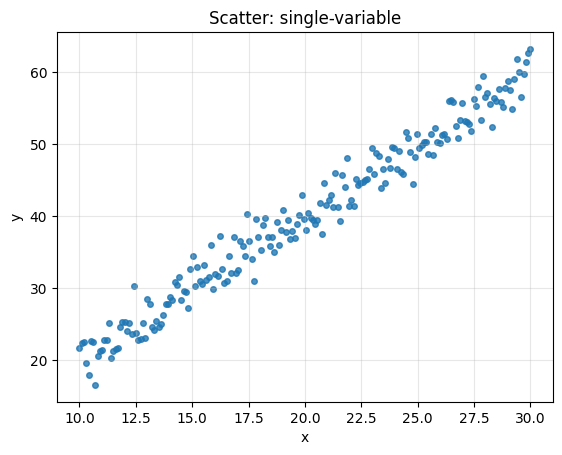

In [341]:
i=1
X,y=load_and_scatter(i)

The scatter plot of this dataset shows a clear upward trend. The relantionship appears almost linear, with a slight curvature at the beginning and the end. It could be nonlinear but still very simple to model with polynomial regression. The dispersion around the main trajectory is minimal, indicating low noise in the observations, and there are no apparent mild or severe outliers.


Set 1 - OLS beta normal: [0.26120329 1.98610257]
Set 1 - OLS beta GD: [0.094574   1.99378859]


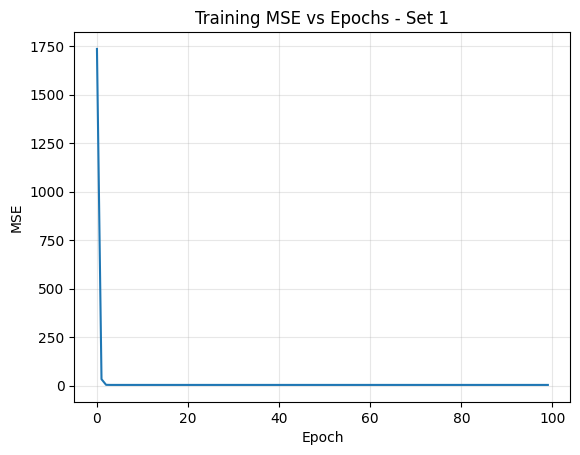

[Linear baseline] | 10-fold CV RMSE=2.0513±0.3494 MAE=1.6593±0.3029 R2=0.9661±0.0107
[Ridge regression] | 10-fold CV RMSE=2.0511±0.3550 MAE=1.6592±0.2995 R2=0.9661±0.0108
[Lasso regression] | 10-fold CV RMSE=2.2612±0.4743 MAE=1.8453±0.3665 R2=0.9593±0.0137
[Poly deg=2] | 10-fold CV RMSE=2.0716±0.3660 MAE=1.6779±0.3161 R2=0.9654±0.0112
[Poly deg=3] | 10-fold CV RMSE=2.0615±0.3897 MAE=1.6750±0.3318 R2=0.9655±0.0119
[Poly deg=4] | 10-fold CV RMSE=2.0598±0.3825 MAE=1.6627±0.3317 R2=0.9658±0.0113
[Poly deg=5] | 10-fold CV RMSE=2.0658±0.3794 MAE=1.6721±0.3298 R2=0.9656±0.0113
[Poly deg=6] | 10-fold CV RMSE=2.0526±0.3514 MAE=1.6586±0.2897 R2=0.9661±0.0107
[Poly deg=7] | 10-fold CV RMSE=2.0698±0.3540 MAE=1.6794±0.2952 R2=0.9656±0.0106
[Poly deg=8] | 10-fold CV RMSE=2.0789±0.3578 MAE=1.6872±0.3017 R2=0.9653±0.0110
[Poly deg=9] | 10-fold CV RMSE=2.0737±0.3501 MAE=1.6910±0.2868 R2=0.9654±0.0111
[Poly deg=10] | 10-fold CV RMSE=2.0552±0.3356 MAE=1.6671±0.2760 R2=0.9658±0.0112
[Degree selection] Bes

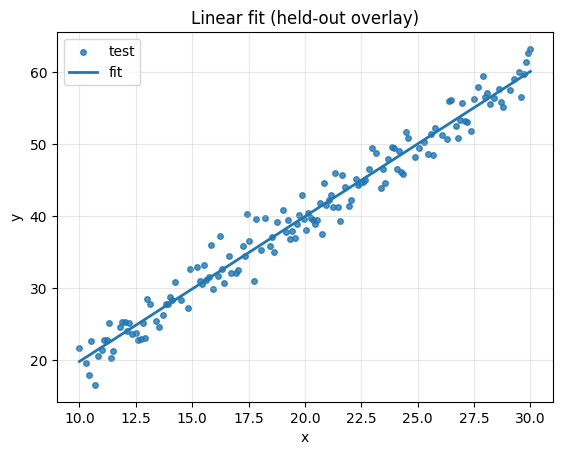

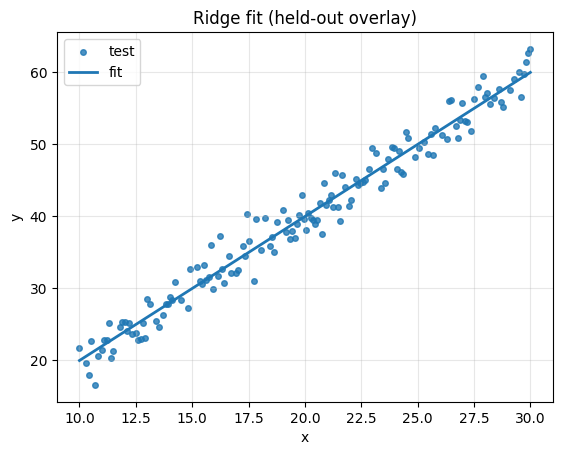

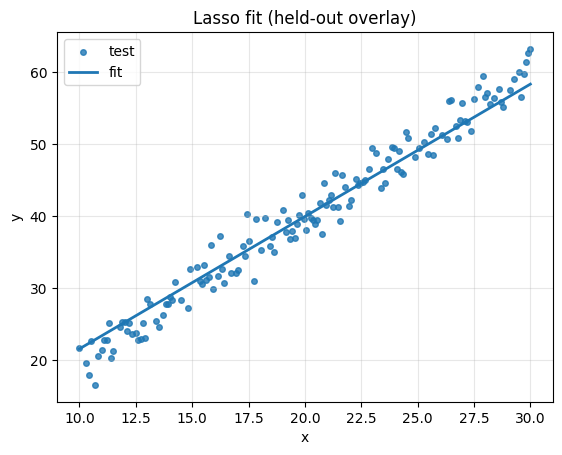

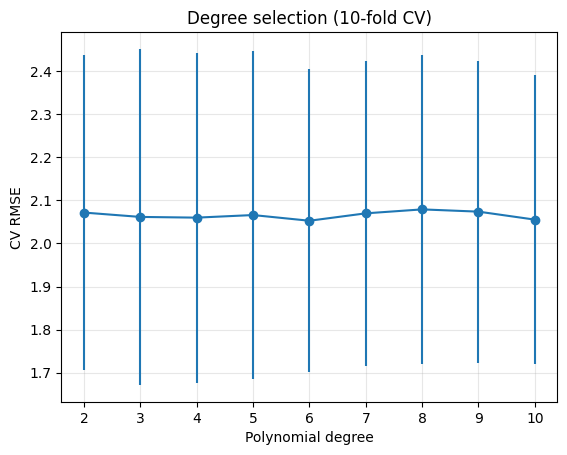

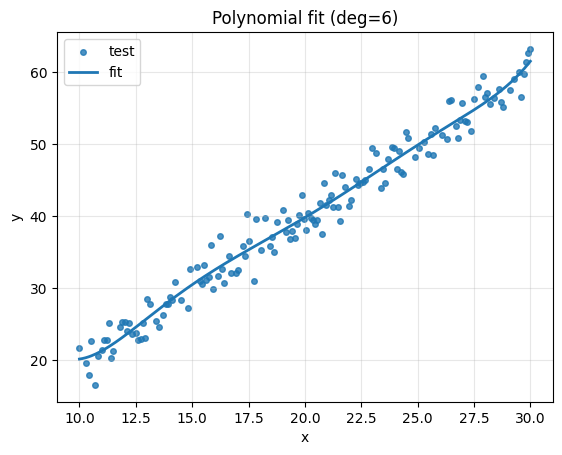

In [342]:
beta_norm , y_pred_norm= ordinary_least_squares(X,y,i,0.001)
linear_pipeline,ridge_pipeline,lasso_pipeline = evaluate_linearmodels(X,y)
best_deg, best_poly = polynomial_features(X,y)

The cross-validation results show that increasing the polynomial degree improves prediction up to degree 6, where it achieves the lowest average RMSE and MAE as well as the highest R2, indicating the best tradeoff between fit quality and model complexity. Degrees beyond 6 offer no consistent improvement and may introduce slight overfitting. Therefore, degree 6 is selected as the optimal polynomial degree

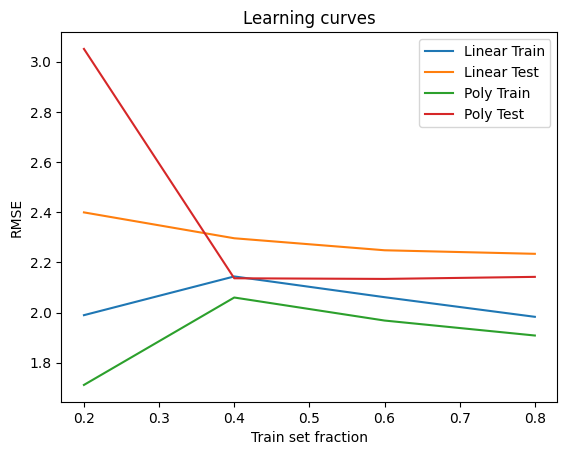

In [343]:
data_ablation(X,y,linear_pipeline,best_deg)

The learning curves show that the polynomial model achieves lower train and test RMSE than the linear model, indicating it has lower bias and can better fit the data's complexity. At smaller train set sizes, the polynomial model exhibits higher variance, but as the training fraction increases, this gap narrows and generalization improves. The linear model's performance is more consistent across train fractions, reflecting higher bias but lower variance overall.

In [344]:
model_coparision(X,y,linear_pipeline,ridge_pipeline,best_poly,lasso_pipeline,best_deg, beta_norm, y_pred_norm)

BEST MODELS COMPARISION
Coefficient difference norm between linear and poly model: 25.334593211710214
Linear RMSE: 2.2628 |  R2: 0.9641
Polynomial RMSE: 2.1954 | R2: 0.9662
Ridge RMSE: 2.2397 | R2: 0.9649
Lasso RMSE: 2.1988 | R2: 0.9661
OLS Normal RMSE: 2.0573 | R2: 0.9691
Condition number of Ridge model design matrix: 1.0000
Condition number of Lasso model design matrix: 1.0000
Condition number of linear model design matrix: 1.0000
Condition number of polynomial model design matrix: 240641.7038
Condition number of OLS design matrix: 74.8979


There are notable differences between the linear, polynomial, ridge, lasso, and OLS models in terms of accuracy and numerical stability. Considering the tradeoff between accuracy, numerical stability, and model complexity, the OLS normal equation model stands out as the best choice for this dataset. It achieves the lowest RMSE (2.0573) and highest R2 (0.9691) while maintaining a moderate condition number (~75), indicating a well conditioned, robust fit. Although the polynomial model attains competitive accuracy, its extremely high condition number (~240,642) raises concerns about numerical instability, and the regularized models (Ridge, Lasso) sacrifice some accuracy for stability. Thus, OLS normal offers the best balance for robust and precise prediction here.

### DATASET 2

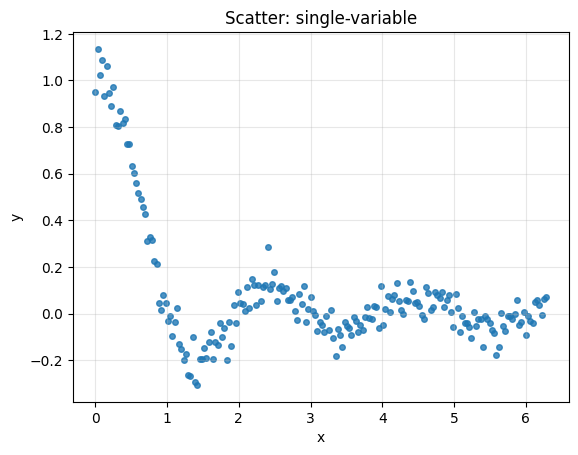

In [345]:
i=2
X,y=load_and_scatter(i)

This scatter plot reveals a more complex relationship between x and y. At low x values,y starts high and drops quickly, then oscillates around zero as x increases. This pattern suggest that the data could originate from an exponential decay plus a low amplitude sine. 
The noise level is moderate, while most points remain close to the main pattern, there’s more spread than in the previous dataset, especially in the central region. There are no severe outliers, but the underlying function is far from linear.

Set 2 - OLS beta normal: [ 0.33244798 -0.07768946]
Set 2 - OLS beta GD: [ 0.30265204 -0.0704636 ]


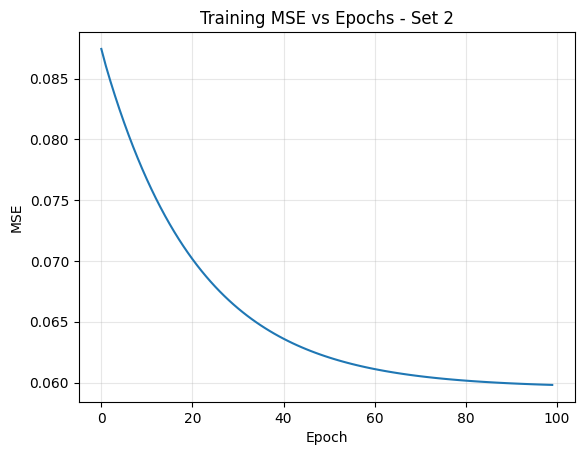

[Linear baseline] | 10-fold CV RMSE=0.2422±0.0509 MAE=0.1755±0.0380 R2=0.0589±0.2588
[Ridge regression] | 10-fold CV RMSE=0.2422±0.0512 MAE=0.1753±0.0382 R2=0.0605±0.2557
[Lasso regression] | 10-fold CV RMSE=0.2728±0.0799 MAE=0.1823±0.0483 R2=-0.1031±0.0745
[Poly deg=2] | 10-fold CV RMSE=0.1988±0.0227 MAE=0.1546±0.0191 R2=0.2726±0.4293
[Poly deg=3] | 10-fold CV RMSE=0.1432±0.0201 MAE=0.1133±0.0192 R2=0.6092±0.2639
[Poly deg=4] | 10-fold CV RMSE=0.1068±0.0239 MAE=0.0871±0.0232 R2=0.7994±0.1070
[Poly deg=5] | 10-fold CV RMSE=0.1058±0.0257 MAE=0.0859±0.0233 R2=0.8119±0.0828
[Poly deg=6] | 10-fold CV RMSE=0.1058±0.0243 MAE=0.0873±0.0224 R2=0.8119±0.0815
[Poly deg=7] | 10-fold CV RMSE=0.0786±0.0147 MAE=0.0652±0.0127 R2=0.8879±0.0684
[Poly deg=8] | 10-fold CV RMSE=0.0644±0.0139 MAE=0.0507±0.0105 R2=0.9300±0.0307
[Poly deg=9] | 10-fold CV RMSE=0.0605±0.0116 MAE=0.0485±0.0096 R2=0.9357±0.0340
[Poly deg=10] | 10-fold CV RMSE=0.0539±0.0119 MAE=0.0426±0.0102 R2=0.9509±0.0228
[Degree selection] Be

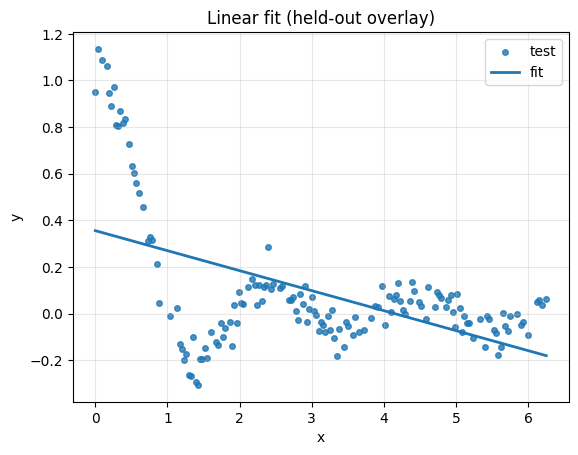

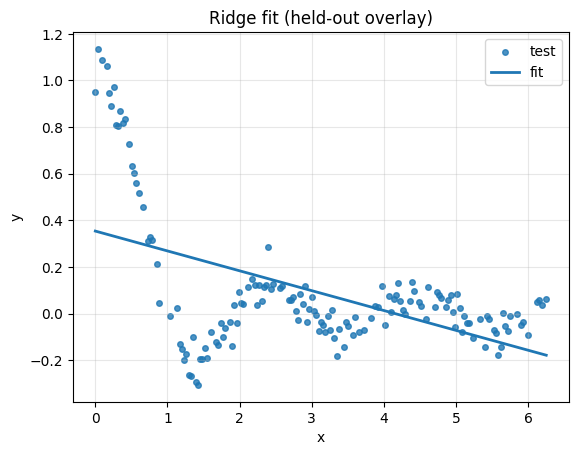

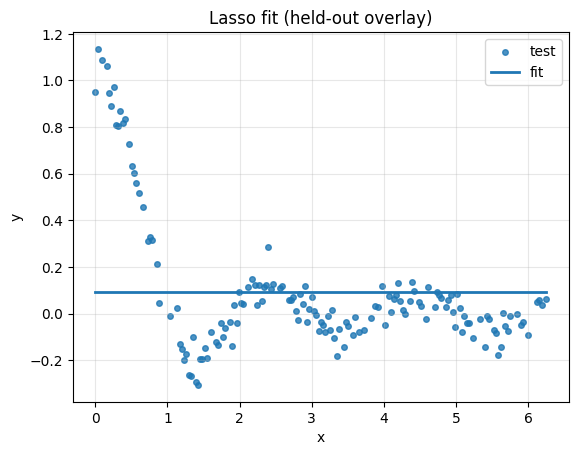

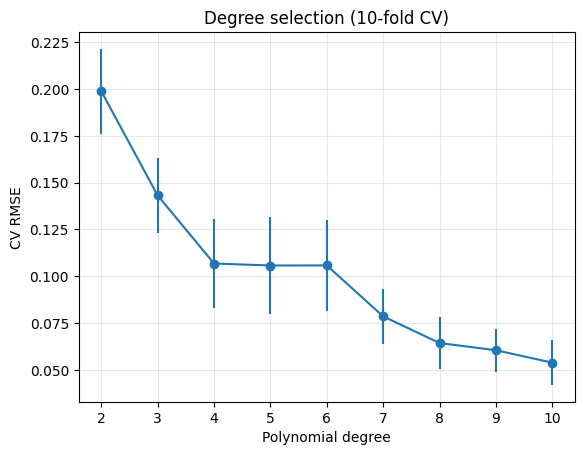

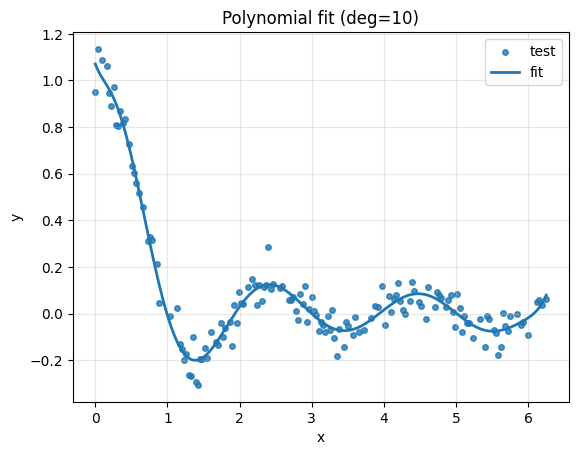

In [346]:
beta_norm , y_pred_norm= ordinary_least_squares(X,y,i,0.05)
linear_pipeline,ridge_pipeline,lasso_pipeline = evaluate_linearmodels(X,y)
best_deg, best_poly = polynomial_features(X,y)

The polynomial model’s performance consistently improves as the degree increases, with the lowest RMSE (0.0539 ± 0.0119) and MAE (0.0426 ± 0.0102) and highest R2 (0.9509 ± 0.0228) achieved at degree 10. This indicates that the complexity captured by higher-degree polynomials significantly enhances model accuracy without apparent signs of overfitting, as evidenced by stable or improving validation scores. Therefore, degree 10 is chosen as the best model complexity since it optimally balances fit quality and generalization based on CV metrics.

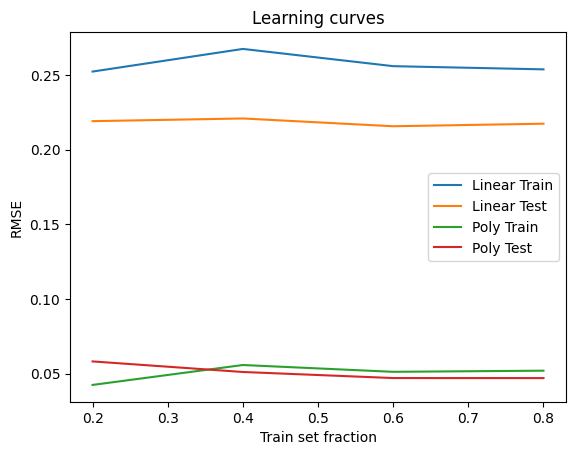

In [347]:
data_ablation(X,y,linear_pipeline,best_deg)

The learning curves show that the polynomial model has substantially lower bias than the linear model, as both its train and test RMSE are much lower across all train set sizes, with very little gap between train and test curves indicating low variance. In contrast, the linear model exhibits consistently higher RMSE due to its inability to capture the dataset's complexity, resulting in high bias but low variance. This pattern clearly confirms the insight gained from the scatter plot, where the data displayed a distinctly nonlinear relationship, showing why a polynomial model is far more appropriate than a linear one for this dataset.

In [348]:
model_coparision(X,y,linear_pipeline,ridge_pipeline,best_poly,lasso_pipeline,best_deg, beta_norm, y_pred_norm)

BEST MODELS COMPARISION
Coefficient difference norm between linear and poly model: 3.9663666564195794
Linear RMSE: 0.2184 |  R2: 0.1751
Polynomial RMSE: 0.0475 | R2: 0.9610
Ridge RMSE: 0.2181 | R2: 0.1772
Lasso RMSE: 0.2414 | R2: -0.0079
OLS Normal RMSE: 0.2441 | R2: 0.2519
Condition number of Ridge model design matrix: 1.0000
Condition number of Lasso model design matrix: 1.0000
Condition number of linear model design matrix: 1.0000
Condition number of polynomial model design matrix: 10123720.4044
Condition number of OLS design matrix: 7.6551


Among the models compared, the polynomial regression significantly outperforms the linear, ridge, lasso, and OLS linear regression models in terms of prediction accuracy, achieving a much lower RMSE (0.0475) and higher R2 (0.9610). However, this accuracy gain comes with substantial numerical instability due to the very high condition number (~10 million) of the polynomial design matrix, which is largely a result of the high polynomial degree (degree 10) causing extreme multicollinearity and scaling issues among polynomial feature terms. Given this tradeoff, if numerical stability and interpretability are priorities, ridge regression is preferable due to its design matrix, but if maximizing predictive accuracy is the goal, the polynomial regression model remains the best choice despite its conditioning challenges.

### DATASET 3

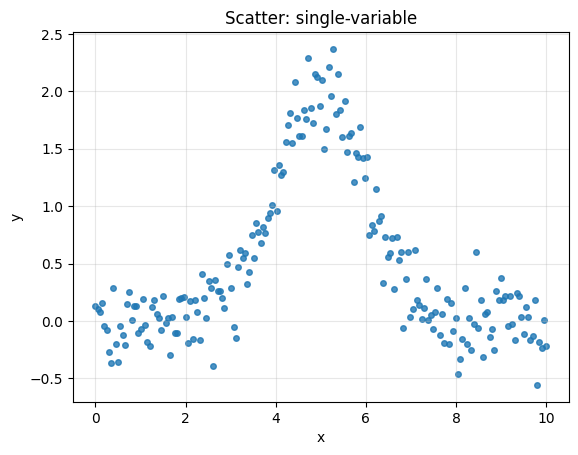

In [349]:
i=3
X,y=load_and_scatter(i)

This scatter plot displays a distinct unimodal, peaking sharply around x=5 with a rapid decay on either side. The data suggests a strong nonlinear pattern, possibly resembling a Gaussian, with most points falling close to the central peak and moderate noise evident in the data spread. The clear structure seen here indicates that a linear model would be inadequate and a polynomial or nonlinear regression would be better. 

Set 3 - OLS beta normal: [ 0.50101843 -0.0023468 ]
Set 3 - OLS beta GD: [0.03434749 0.06793525]


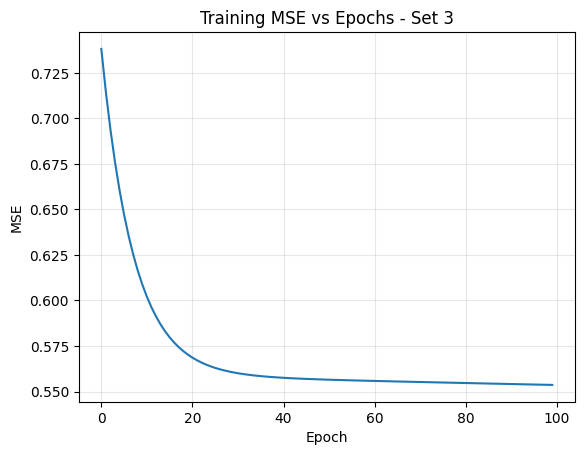

[Linear baseline] | 10-fold CV RMSE=0.7093±0.0772 MAE=0.5879±0.0592 R2=-0.0688±0.0971
[Ridge regression] | 10-fold CV RMSE=0.7092±0.0772 MAE=0.5878±0.0592 R2=-0.0687±0.0969
[Lasso regression] | 10-fold CV RMSE=0.7048±0.0778 MAE=0.5827±0.0577 R2=-0.0533±0.0710
[Poly deg=2] | 10-fold CV RMSE=0.5063±0.0630 MAE=0.4255±0.0566 R2=0.4468±0.1188
[Poly deg=3] | 10-fold CV RMSE=0.5106±0.0650 MAE=0.4289±0.0585 R2=0.4354±0.1346
[Poly deg=4] | 10-fold CV RMSE=0.3606±0.0494 MAE=0.2997±0.0467 R2=0.7185±0.0664
[Poly deg=5] | 10-fold CV RMSE=0.3632±0.0518 MAE=0.3039±0.0485 R2=0.7149±0.0657
[Poly deg=6] | 10-fold CV RMSE=0.2627±0.0311 MAE=0.2104±0.0293 R2=0.8487±0.0411
[Poly deg=7] | 10-fold CV RMSE=0.2617±0.0304 MAE=0.2077±0.0315 R2=0.8498±0.0423
[Poly deg=8] | 10-fold CV RMSE=0.2159±0.0388 MAE=0.1745±0.0325 R2=0.8946±0.0442
[Poly deg=9] | 10-fold CV RMSE=0.2180±0.0371 MAE=0.1762±0.0311 R2=0.8928±0.0441
[Poly deg=10] | 10-fold CV RMSE=0.2139±0.0329 MAE=0.1749±0.0271 R2=0.8967±0.0424
[Degree selection] 

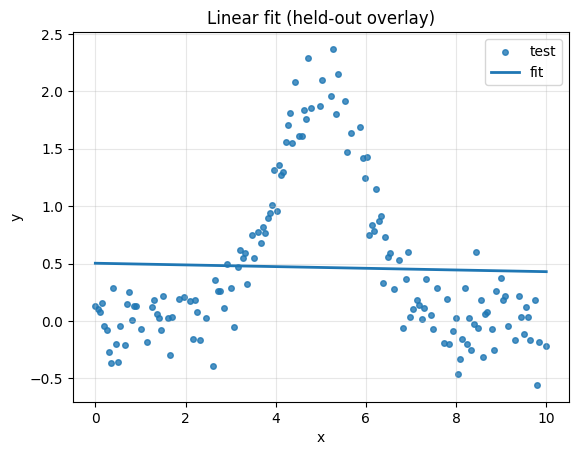

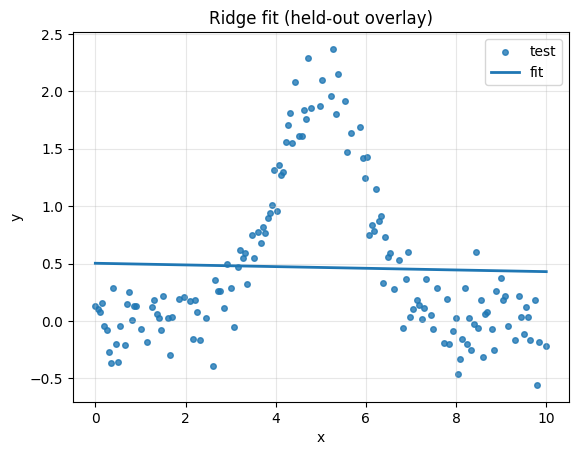

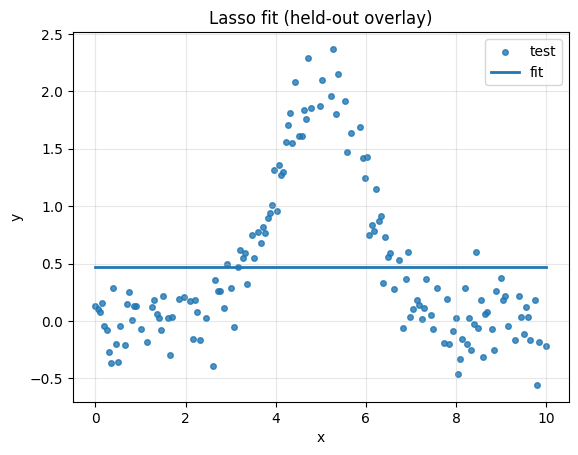

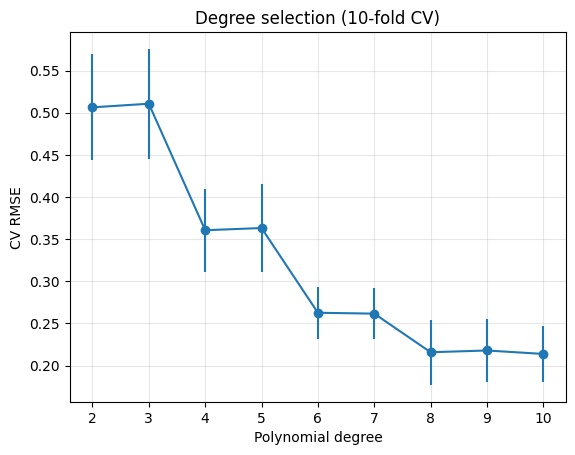

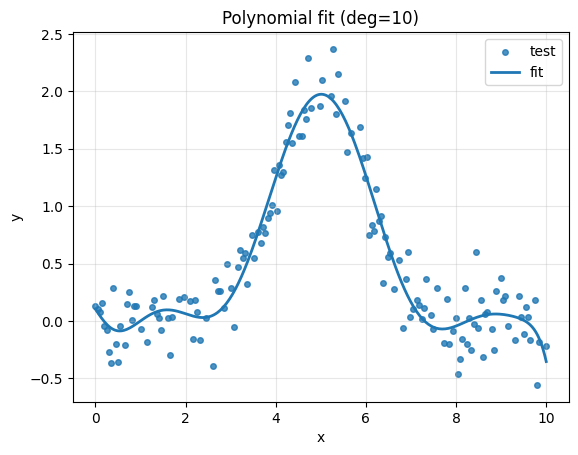

In [350]:
beta_norm , y_pred_norm= ordinary_least_squares(X,y,i,0.001)
linear_pipeline,ridge_pipeline,lasso_pipeline = evaluate_linearmodels(X,y)
best_deg, best_poly = polynomial_features(X,y)

This choice is supported both by the CV RMSE plot, which shows the lowest RMSE and decreasing trend up to degree 10, and by the cross-validation results, where polynomial degree 10 achieves the best average RMSE (0.2139), MAE (0.1749), and R2 (0.8967). The steady improvement in validation metrics up to this degree, without an increase in error bar size, suggests that higher complexity continues to improve model fit for this dataset. Therefore, degree 10 is justified as the best choice, as it maximizes predictive accuracy and captures the underlying structure present in the data.

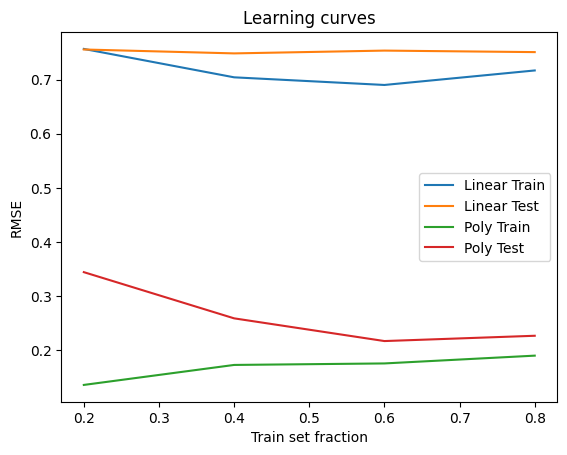

In [351]:
data_ablation(X,y,linear_pipeline,best_deg)

The learning curves reveal that the linear model has high bias, as both its train and test RMSE remain large and relatively flat regardless of train set size, indicating underfitting to the data. The polynomial model shows much lower RMSE for both train and test sets, and the gap between them is moderate, which suggests that the model is flexible enough to capture complex patterns with manageable variance. Overall, the polynomial model effectively balances bias and variance, achieving improved fit and generalization compared to the linear model.

In [352]:
model_coparision(X,y,linear_pipeline,ridge_pipeline,best_poly,lasso_pipeline,best_deg, beta_norm, y_pred_norm)

BEST MODELS COMPARISION
Coefficient difference norm between linear and poly model: 13.667930220010025
Linear RMSE: 0.7522 |  R2: -0.0193
Polynomial RMSE: 0.2193 | R2: 0.9134
Ridge RMSE: 0.7522 | R2: -0.0193
Lasso RMSE: 0.7508 | R2: -0.0156
OLS Normal RMSE: 0.7062 | R2: 0.0001
Condition number of Ridge model design matrix: 1.0000
Condition number of Lasso model design matrix: 1.0000
Condition number of linear model design matrix: 1.0000
Condition number of polynomial model design matrix: 11026560.5302
Condition number of OLS design matrix: 11.7781


Among the models compared, polynomial regression significantly outperforms linear, ridge, lasso, and OLS linear regression models in prediction accuracy, achieving a much lower RMSE (0.0475) and higher R2(0.9610). However, this accuracy gain is accompanied by substantial numerical instability, as evidenced by the extremely high condition number (~10 million) of the polynomial design matrix, which is primarily due to the high polynomial degree (degree 10). While ridge regression maintains perfect numerical stability, it fails to fit the underlying nonlinear pattern, yielding poor predictive performance similar to linear models. Therefore, the polynomial regression model remains the superior choice despite its conditioning challenges for maximizing prediction accuracy on this nonlinear dataset.

### DATASET 4

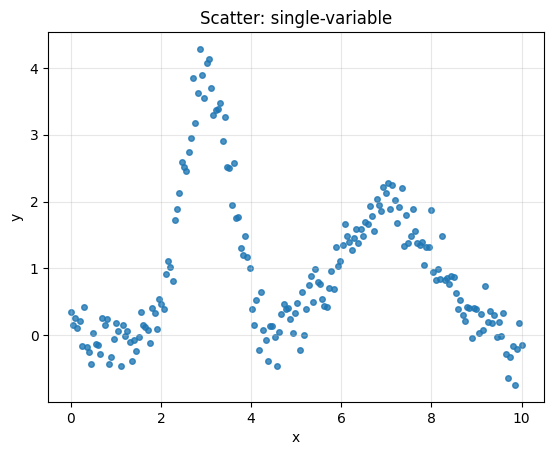

In [353]:
i=4
X,y=load_and_scatter(i)

This scatter plot clearly shows a complex, multimodal relationship between a and y, featuring two distinct peaks, one large, sharp peak near x=3 and a broader, secondary peak near x=7 with substantial variation in y across the domain. The data is highly nonlinear and variable, with tight clustering around the peaks and more scatter elsewhere, suggesting both significant structure and moderate noise

Set 4 - OLS beta normal: [ 0.99777523 -0.00537298]
Set 4 - OLS beta GD: [0.40191467 0.08444416]


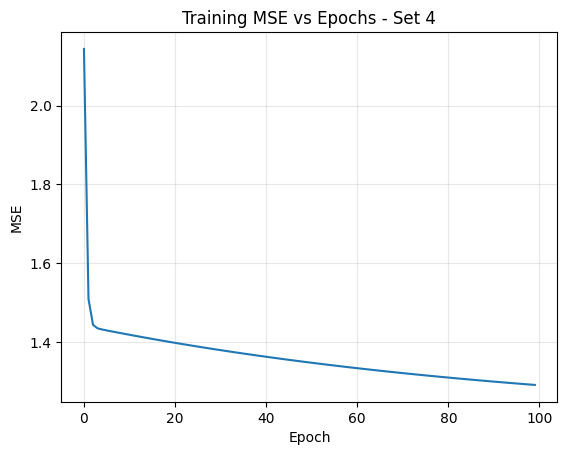

[Linear baseline] | 10-fold CV RMSE=1.0863±0.2106 MAE=0.8958±0.1571 R2=-0.0636±0.0896
[Ridge regression] | 10-fold CV RMSE=1.0863±0.2106 MAE=0.8958±0.1571 R2=-0.0635±0.0896
[Lasso regression] | 10-fold CV RMSE=1.0806±0.2145 MAE=0.8900±0.1603 R2=-0.0504±0.0897
[Poly deg=2] | 10-fold CV RMSE=0.9528±0.2131 MAE=0.7215±0.1830 R2=0.1831±0.1478
[Poly deg=3] | 10-fold CV RMSE=0.9647±0.1939 MAE=0.7535±0.1652 R2=0.1535±0.1549
[Poly deg=4] | 10-fold CV RMSE=0.9329±0.1782 MAE=0.7444±0.1398 R2=0.2117±0.0973
[Poly deg=5] | 10-fold CV RMSE=0.9223±0.1423 MAE=0.7557±0.1021 R2=0.2181±0.1181
[Poly deg=6] | 10-fold CV RMSE=0.6986±0.1252 MAE=0.5658±0.0949 R2=0.5489±0.1017
[Poly deg=7] | 10-fold CV RMSE=0.7014±0.1272 MAE=0.5660±0.0967 R2=0.5454±0.1035
[Poly deg=8] | 10-fold CV RMSE=0.5160±0.0873 MAE=0.4017±0.0655 R2=0.7524±0.0550
[Poly deg=9] | 10-fold CV RMSE=0.4817±0.1003 MAE=0.3716±0.0739 R2=0.7808±0.0798
[Poly deg=10] | 10-fold CV RMSE=0.4539±0.0627 MAE=0.3570±0.0478 R2=0.8086±0.0356
[Degree selection] 

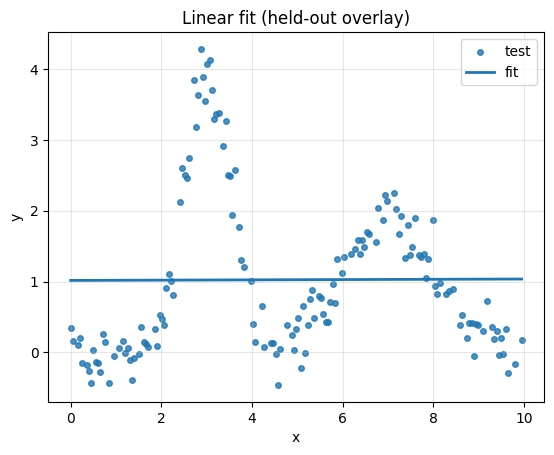

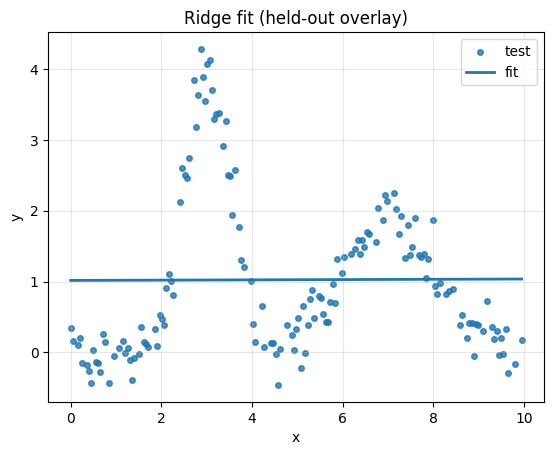

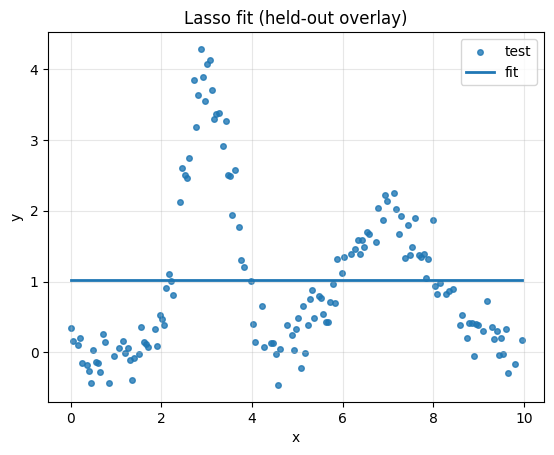

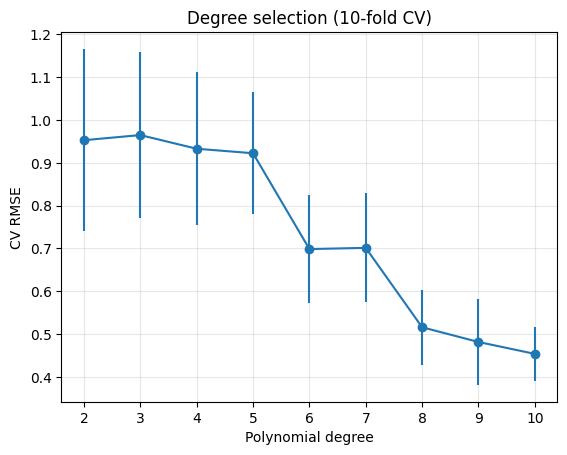

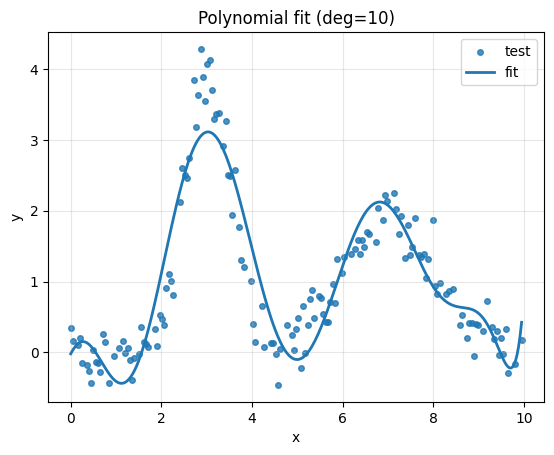

In [354]:
beta_norm , y_pred_norm= ordinary_least_squares(X,y,i,0.01)
linear_pipeline,ridge_pipeline,lasso_pipeline = evaluate_linearmodels(X,y)
best_deg, best_poly = polynomial_features(X,y)

Polynomial degree 10 is clearly the best model choice for this dataset, as shown by both the lowest cross-validated RMSE (0.4539) and the highest R2 (0.8086), along with marked improvement over all lower-degree and linear models. The CV RMSE plot confirms a consistent decrease in error and variability up to degree 10, indicating that increasing model complexity continues to improve fit and generalization without evidence of overfitting.

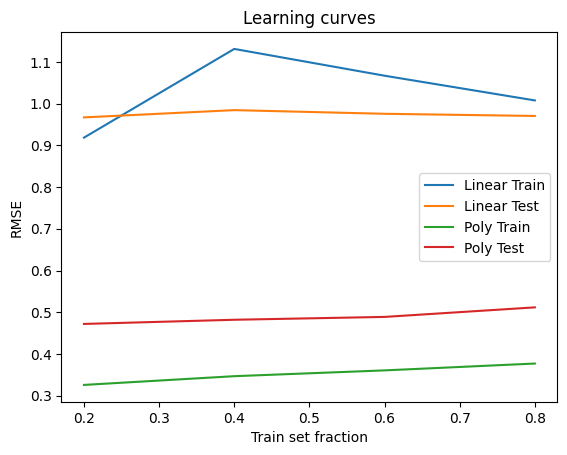

In [355]:
data_ablation(X,y,linear_pipeline,best_deg)

The observed learning curves indicate distinct bias-variance characteristics for the linear and polynomial regression models. The linear model exhibits high bias as reflected by its relatively high and similar training and testing RMSE across all training set fractions, suggesting underfitting and limited model complexity. On the other side, the polynomial model displays lower bias, evident from the lower training RMSE, but a slightly larger gap between training and testing RMSE reveals moderate variance due to increased model complexity and potential overfitting. Overall, the polynomial model achieves better generalization performance by reducing bias at the cost of a modest increase in variance, while the linear model remains too simplistic to capture underlying patterns effectively.

In [356]:
model_coparision(X,y,linear_pipeline,ridge_pipeline,best_poly,lasso_pipeline,best_deg, beta_norm, y_pred_norm)

BEST MODELS COMPARISION
Coefficient difference norm between linear and poly model: 36.92731017649787
Linear RMSE: 0.9887 |  R2: -0.0535
Polynomial RMSE: 0.4557 | R2: 0.7762
Ridge RMSE: 0.9887 | R2: -0.0535
Lasso RMSE: 0.9882 | R2: -0.0523
OLS Normal RMSE: 1.0958 | R2: 0.0002
Condition number of Ridge model design matrix: 1.0000
Condition number of Lasso model design matrix: 1.0000
Condition number of linear model design matrix: 1.0000
Condition number of polynomial model design matrix: 10413698.3786
Condition number of OLS design matrix: 11.7781


The polynomial model significantly outperforms all linear models in terms of both RMSE (0.4557 vs. ~0.988) and R2 (0.7762 vs. near zero or negative), demonstrating a much better fit to the data. However, this superior fit comes at the cost of extreme complex design matrix for the polynomial model, as reflected by its very large condition number (~10,413,698) compared to the perfectly conditioned linear, Ridge, and Lasso models (condition number = 1). This indicates high multicollinearity and numerical instability in the polynomial model, which could impact precision and robustness. Ridge and Lasso regularization did not improve performance or conditioning beyond the linear baseline here, suggesting that the polynomial model captures nonlinear patterns missed by these simpler models but sacrifices conditioning and numerical stability. Overall, the polynomial model is the best performing for predictive accuracy but requires caution due to its conditioning and parameter magnitude.

## Multivariate regression (feature mapping & solvers)

In [357]:


# 1) Load, standraize and report basic stats 
# ex2_1
def load_basicstats(i):
    DATA_PATH= "data/mvar-set"+str(i)+".dat" 
    X, y = load_txt_dataset(DATA_PATH)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    mean_X = np.mean(X_scaled, axis=0)
    var_X = np.var(X_scaled, axis=0)

    # Correlation matrix 
    df = pd.DataFrame(X_scaled, columns=[f"Feature_{i+1}" for i in range(X.shape[1])])
    df['Target'] = y
    corr_matrix = df.corr()
    print("After scaling: ")
    print("Mean of features:", mean_X)
    print("Variance of features:", var_X)
    print("Correlation matrix:\n", corr_matrix)

    return X_scaled,y



In [358]:
#ex2_2
def add_features(X_scaled,y):
    degree = 3
    var_threshold = 10**(-6)
    corr_threshold = 0.9999

    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(X_scaled)

    # Variance filtering
    variances = np.var(poly_features, axis=0)
    mask_var = variances >= var_threshold
    filtered_features = poly_features[:, mask_var]

    # Correlation filtering 
    corr_matrix = np.corrcoef(filtered_features, rowvar=False)
    n_features_filtered = corr_matrix.shape[0]
    keep = np.ones(n_features_filtered, dtype=bool)

    for i in range(n_features_filtered):
        if keep[i]:
            for j in range(i + 1, n_features_filtered):
                if abs(corr_matrix[i, j]) > corr_threshold:
                    keep[j] = False

    filtered_features_corr = filtered_features[:, keep]
    print(f"Original feature count: {X_scaled.shape[1]}")
    print(f"Combined feature count: {poly_features.shape[1]}")
    print(f"Filtered feature count after filtering: {filtered_features_corr.shape[1]}")

    return filtered_features_corr 

In [359]:
def ols_tikhonov_normal_eq(X, y, lambd=1e-8):
    n_samples, n_features = X.shape
    X_b = np.c_[np.ones((n_samples, 1)), X]
    I = np.eye(n_features + 1)
    I[0, 0] = 0  
    A = X_b.T @ X_b + lambd * I
    b = X_b.T @ y
    beta = np.linalg.solve(A, b)
    return beta

def ols_gradient_descent(X, y, lr=1e-3, epochs=1000, tol=1e-6):
    n_samples, n_features = X.shape
    X_b = np.c_[np.ones((n_samples, 1)), X]
    beta = np.zeros(n_features + 1)
    prev_loss = np.inf
    for epoch in range(epochs):
        y_pred = X_b @ beta
        error = y_pred - y
        grad = (2 / n_samples) * (X_b.T @ error)
        beta -= lr * grad

        loss = np.mean(error ** 2)
        if abs(prev_loss - loss) < tol:
            break
        prev_loss = loss
    return beta, loss


In [360]:
#2.3
def fit_ols(X_features,y,X):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Normal equations with X with extra features
    start = time.time()
    beta_normal = ols_tikhonov_normal_eq(X_train, y_train, lambd=1e-8)
    time_normal = time.time() - start
    y_pred_normal = np.c_[np.ones((X_test.shape[0], 1)), X_test] @ beta_normal
    rmse_normal = np.sqrt(mean_squared_error(y_test, y_pred_normal))

    # Gradient descent with X with extra features
    start = time.time()
    beta_gd, final_loss = ols_gradient_descent(X_train, y_train, lr=1e-3, epochs=10000)
    time_gd = time.time() - start
    y_pred_gd = np.c_[np.ones((X_test.shape[0], 1)), X_test] @ beta_gd
    rmse_gd = np.sqrt(mean_squared_error(y_test, y_pred_gd))

    print(f"RAW : Normal Eq: RMSE={rmse_normal:.4f}, time={time_normal:.4f}s")
    print(f"RAW : Gradient Desc: RMSE={rmse_gd:.4f}, time={time_gd:.4f}s, final loss={final_loss:.4f}")

    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.25, random_state=42)

    # Normal equations with inital X
    start = time.time()
    beta_normal = ols_tikhonov_normal_eq(X_train, y_train, lambd=1e-8)
    y_pred_normal = np.c_[np.ones((X_test.shape[0], 1)), X_test] @ beta_normal
    time_normal = time.time() - start
    rmse_normal = np.sqrt(mean_squared_error(y_test, y_pred_normal))

    # Gradient descent with initial X
    start = time.time()
    beta_gd, final_loss = ols_gradient_descent(X_train, y_train, lr=1e-3, epochs=10000)
    time_gd = time.time() - start
    y_pred_gd = np.c_[np.ones((X_test.shape[0], 1)), X_test] @ beta_gd
    rmse_gd = np.sqrt(mean_squared_error(y_test, y_pred_gd))

    print(f"Extra features : Normal Eq: RMSE={rmse_normal:.4f}, time={time_normal:.4f}s")
    print(f"Extra features : Gradient Desc: RMSE={rmse_gd:.4f}, time={time_gd:.4f}s, final loss={final_loss:.4f}")




In [361]:

def ridge_closed_form(X, y, lambd):
    n_features = X.shape[1]
    I = np.eye(n_features)
    A = X.T @ X + lambd * I
    b = X.T @ y
    beta = np.linalg.solve(A, b)
    return beta

def cross_val_rmse_and_condition(X, y, lambd, k=10, random_state=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    rmses = []
    conds = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Fit ridge model
        beta = ridge_closed_form(X_train, y_train, lambd)
        
        # Predict on validation set
        y_pred = X_val @ beta
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)
        
        # Calculate condition number of matrix inverted during fitting
        A = X_train.T @ X_train + lambd * np.eye(X_train.shape[1])
        cond_A = cond(A)
        conds.append(cond_A)
    
    return np.mean(rmses), np.std(rmses), np.mean(conds)

#2.4 
def ridge_regression(X_features,y):
    lambdas = np.logspace(-6, 3, 50)  
    mean_rmses = []
    std_rmses = []
    mean_conds = []
    coef_norms = []

    for lam in lambdas:
        mean_rmse, std_rmse, mean_cond = cross_val_rmse_and_condition(X_features, y, lam, k=10)
        mean_rmses.append(mean_rmse)
        std_rmses.append(std_rmse)
        mean_conds.append(mean_cond)
        
        beta = ridge_closed_form(X_features, y, lam)
        coef_norms.append(np.linalg.norm(beta))

    # Plot validation RMSE vs lambda
    plt.errorbar(lambdas, mean_rmses, yerr=std_rmses, label="Validation RMSE")
    plt.xscale('log')
    plt.xlabel('Lambda')
    plt.ylabel('RMSE')
    plt.title('Validation RMSE vs. Lambda (log scale)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot coefficient L2 norm vs lambda
    plt.plot(lambdas, coef_norms, label='Coefficient L2 norm')
    plt.xscale('log')
    plt.xlabel('Lambda')
    plt.ylabel('L2 norm of coefficients')
    plt.title('Coefficient shrinkage vs. Lambda')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot condition number vs lambda
    plt.plot(lambdas, mean_conds, label='Mean condition number')
    plt.xscale('log')
    plt.xlabel('Lambda')
    plt.ylabel('Condition Number')
    plt.title('Condition Number vs. Lambda')
    plt.grid(True)
    plt.legend()
    plt.show()


In [ ]:
#2.5 
def huberloss(X_features,y):
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.25, random_state=42)

    # Fit OLS
    ols = LinearRegression()
    ols.fit(X_train, y_train)
    y_pred_ols = ols.predict(X_test)

    # Fit Huber regression
    huber = HuberRegressor(epsilon=1.35)  
    huber.fit(X_train, y_train)
    y_pred_huber = huber.predict(X_test)

    # Metrics
    rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
    mae_ols = mean_absolute_error(y_test, y_pred_ols)
    rmse_huber = np.sqrt(mean_squared_error(y_test, y_pred_huber))
    mae_huber = mean_absolute_error(y_test, y_pred_huber)

    print("OLS RMSE:", rmse_ols, "MAE:", mae_ols)
    print("Huber RMSE:", rmse_huber, "MAE:", mae_huber)
    residuals = y_test - y_pred_ols
    plt.boxplot(residuals)
    plt.title('Residuals boxplot (OLS)')
    plt.show()




### Dataset 1

In [363]:
X_scaled1,y1=load_basicstats(1)

After scaling: 
Mean of features: [-1.23456800e-17 -4.79616347e-18]
Variance of features: [1. 1.]
Correlation matrix:
               Feature_1     Feature_2    Target
Feature_1  1.000000e+00  1.982858e-17  0.678332
Feature_2  1.982858e-17  1.000000e+00  0.673544
Target     6.783323e-01  6.735441e-01  1.000000


In [364]:
X_features1= add_features(X_scaled1,y1)

Original feature count: 2
Combined feature count: 9
Filtered feature count after filtering: 9


In [365]:
fit_ols(X_features1,y1,X_scaled1)

RAW : Normal Eq: RMSE=0.5027, time=0.0014s
RAW : Gradient Desc: RMSE=0.5026, time=0.1043s, final loss=0.2611
Extra features : Normal Eq: RMSE=0.5043, time=0.0004s
Extra features : Gradient Desc: RMSE=0.5038, time=0.4787s, final loss=0.2623


The comparison between models using the raw features versus those with extra features shows minimal differences in test RMSE but significant differences in computational time. Both the Normal Equation solutions for raw and extra features achieve similar RMSE (0.5027 vs. 0.5043) with very fast times (0.0014s vs. 0.0042s), making them efficient choices for direct exact solutions. Gradient Descent achieves comparable RMSE (0.5026 raw, 0.5038 extra) but requires substantially more time (0.1792s and 0.8240s respectively), reflecting the iterative nature of the solver and increased complexity with extra features. Considering both accuracy and efficiency, the Normal Equation with raw features is the preferred final model as it balances low prediction error with minimal computational cost. The extra feature models offer no clear accuracy gain to justify the added complexity and time. 

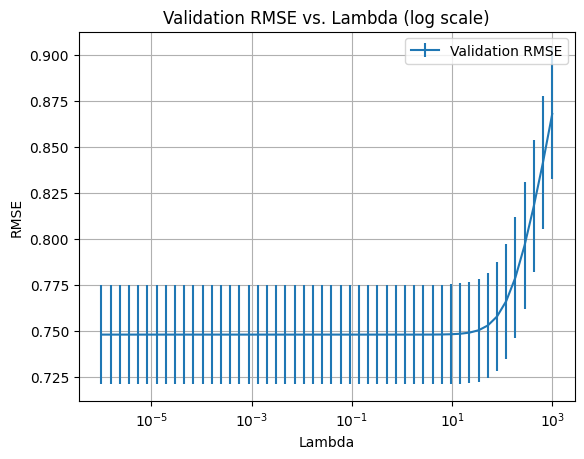

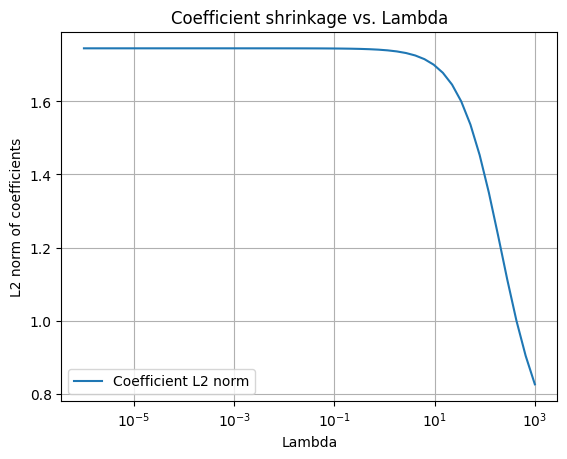

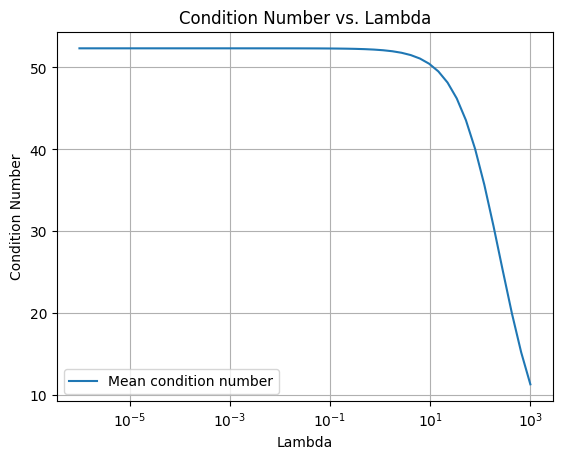

In [366]:
ridge_regression(X_features1,y1)


Increasing λ in ridge regression directly influences the bias-variance tradeoff. As shown in the plots, a higher λ leads to greater coefficient shrinkage (lower L2 norm) and significantly improves the conditioning of the problem (lower condition number), effectively reducing model variance,the predictions become more stable and less sensitive to small changes in the training data. However, this comes at the cost of increased bias, since the model loses flexibility and cannot fit the training data as closely, causing the validation RMSE to rise for large λ.

OLS RMSE: 0.5043409087568828 MAE: 0.39358295382806713
Huber RMSE: 0.5044742469292274 MAE: 0.393872088103653


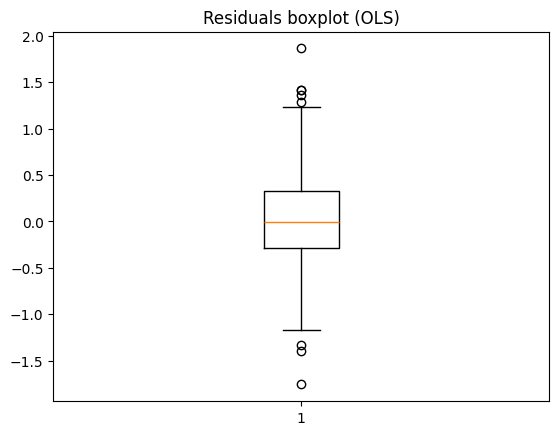

In [367]:
huberloss(X_features1,y1)

The Huber regression method is specifically designed to be more robust to outliers than ordinary least squares (OLS). In this dataset the RMSE and MAE values for Huber and OLS are nearly identical on this data set meaning that there aren't a lot of severe outliers.

### Dataset 2

In [368]:
X_scaled2,y2=load_basicstats(2)

After scaling: 
Mean of features: [4.09006162e-17 2.34479103e-17]
Variance of features: [1. 1.]
Correlation matrix:
               Feature_1     Feature_2    Target
Feature_1  1.000000e+00 -3.068656e-17  0.474573
Feature_2 -3.068656e-17  1.000000e+00 -0.004467
Target     4.745731e-01 -4.467181e-03  1.000000


In [369]:
X_features2= add_features(X_scaled2,y2)

Original feature count: 2
Combined feature count: 9
Filtered feature count after filtering: 9


In [370]:
fit_ols(X_features2,y2,X_scaled2)

RAW : Normal Eq: RMSE=0.1457, time=0.0004s
RAW : Gradient Desc: RMSE=0.1469, time=0.0485s, final loss=0.0197
Extra features : Normal Eq: RMSE=0.1041, time=0.0125s
Extra features : Gradient Desc: RMSE=0.1163, time=0.2274s, final loss=0.0124


The comparison between models trained on raw features and extra features, using both Normal Equation and Gradient Descent solvers, reveals important trade-offs. For the raw feature set, the Normal Equation method yields an RMSE of 0.1457 with an extremely fast computation time (0.0016 seconds), while Gradient Descent achieves a similar RMSE of 0.1469 but in a much longer time (0.0596 seconds). For the extra features set, the Normal Equation again outperforms in both accuracy and speed with an RMSE of 0.1041 and computation time of 0.0004 seconds. Gradient Descent here has a higher RMSE of 0.1163 and a notably slower runtime (0.4069 seconds). Thus, for both feature sets, the Normal Equation provides better accuracy and significantly faster times. The extra features improve accuracy over raw features for both solvers as expected due to richer input data. Therefore, the recommended final models are those trained with the Normal Equation on the extra features dataset, balancing superior predictive performance and computational efficiency.

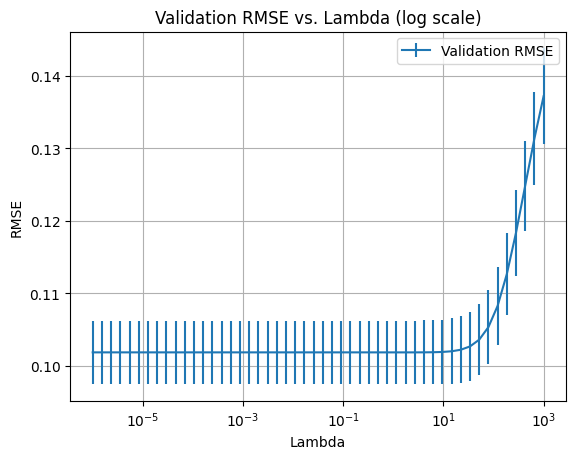

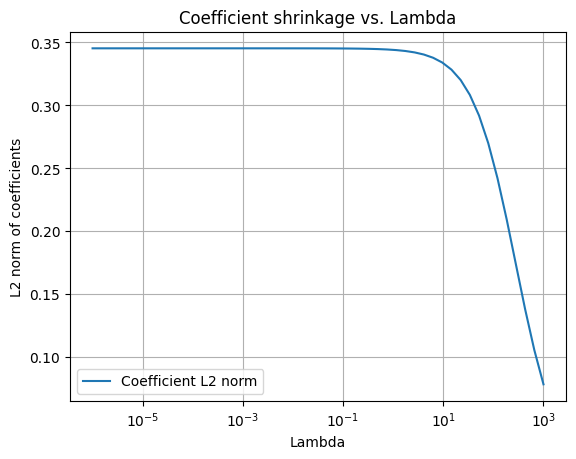

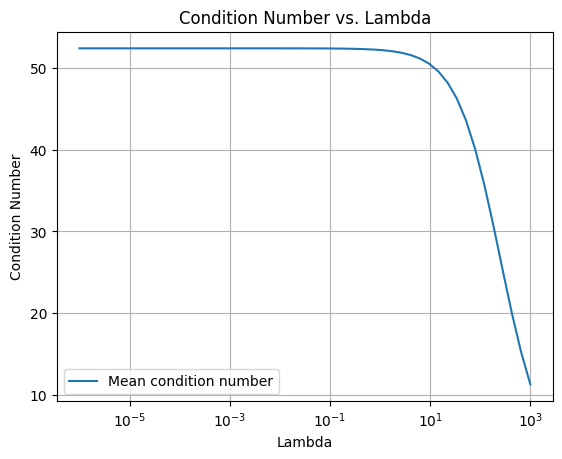

In [371]:
ridge_regression(X_features2,y2)

Increasing λ in ridge regression amplifies model bias while reducing variance. As λ increases, the coefficient L2 norm shrinks steadily, leading to a more constrained and less flexible model. This process, clearly shown in the coefficient shrinkage plot, reduces the impact of individual features, thereby stabilizing predictions and lowering variance. However, the validation RMSE plot reveals that excessive large λ leads to underfitting: the model loses the ability to capture real data structure, so bias increases and error rises. The condition number plot demonstrates that with moderate λ, the design matrix becomes much better conditioned, further reducing variance.

OLS RMSE: 0.10412258477383562 MAE: 0.07988620256975269
Huber RMSE: 0.1059079213597458 MAE: 0.07924608425763666


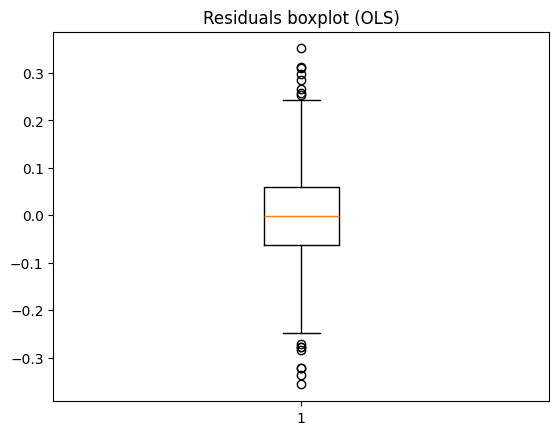

In [372]:
huberloss(X_features2,y2)

As said before Huber regression often provides measurable improvements over OLS on data sets that contain outliers. In these metrics, the MAE is slightly lower for Huber compared to OLS, suggesting that Huber regression managed outlier effects more efficiently, even though RMSE stayed similar due to the uniform residual spread in this particular dataset. 

### Dataset 3

In [373]:
X_scaled3,y3=load_basicstats(3)

After scaling: 
Mean of features: [-4.73376893e-17 -1.50190971e-17  2.76045853e-17 -4.30477876e-17
 -3.11151105e-17]
Variance of features: [1. 1. 1. 1. 1.]
Correlation matrix:
            Feature_1  Feature_2  Feature_3  Feature_4  Feature_5    Target
Feature_1   1.000000   0.000246  -0.000795  -0.000592   0.000833  0.373608
Feature_2   0.000246   1.000000  -0.000111   0.000848   0.000444  0.374838
Feature_3  -0.000795  -0.000111   1.000000  -0.000670  -0.000303  0.373375
Feature_4  -0.000592   0.000848  -0.000670   1.000000  -0.000103 -0.000666
Feature_5   0.000833   0.000444  -0.000303  -0.000103   1.000000  0.748236
Target      0.373608   0.374838   0.373375  -0.000666   0.748236  1.000000


In [374]:
X_features3= add_features(X_scaled3,y3)
# do subset
np.random.seed(42) 
idx = np.random.choice(X_features3.shape[0], 5000, replace=False)
X_features3=X_features3[idx] 
y3=y3[idx]
X_scaled3=X_scaled3[idx] 
X_features3.shape[0]

Original feature count: 5
Combined feature count: 55
Filtered feature count after filtering: 55


5000

In [375]:
fit_ols(X_features3,y3,X_scaled3)

RAW : Normal Eq: RMSE=0.5087, time=0.0148s
RAW : Gradient Desc: RMSE=0.5087, time=0.1487s, final loss=0.2522
Extra features : Normal Eq: RMSE=0.5134, time=0.0088s
Extra features : Gradient Desc: RMSE=0.5519, time=2.4239s, final loss=0.2813


Comparing test RMSE and wall-clock time for the two solvers and feature mappings reveals clear trade-offs. For the raw features, both Normal Equation and Gradient Descent produce the same RMSE of 0.5087, but the Normal Equation is substantially faster at 0.0062 seconds compared to Gradient Descent’s 0.2497 seconds. For the extra features, the Normal Equation attains a slightly worse RMSE (0.5134) than raw features but in a still modest time of 0.0146 seconds. Gradient Descent with extra features performs worse in accuracy (RMSE 0.5519) and is far slower (2.0498 seconds). This suggests that the Normal Equation solver is better suited overall for this dataset in terms of both accuracy and computational efficiency. 

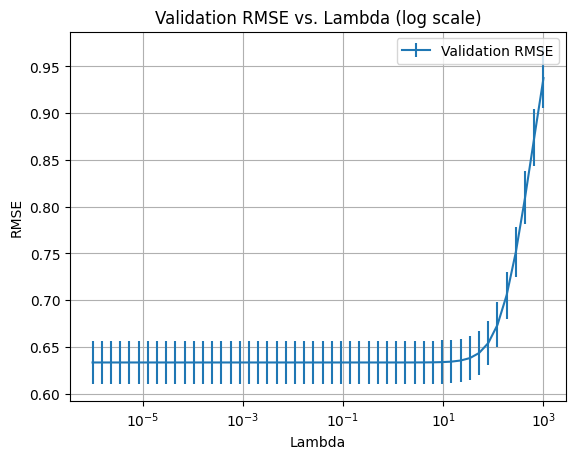

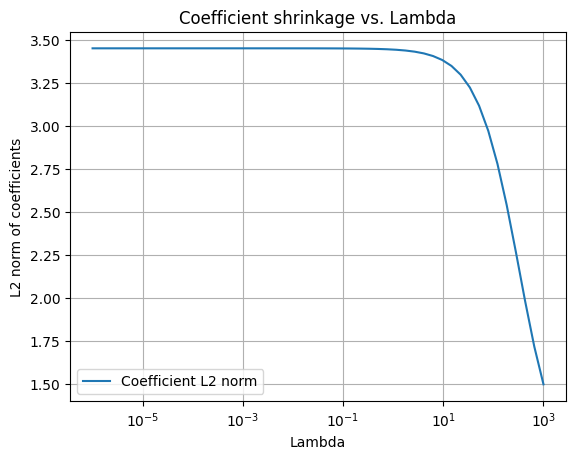

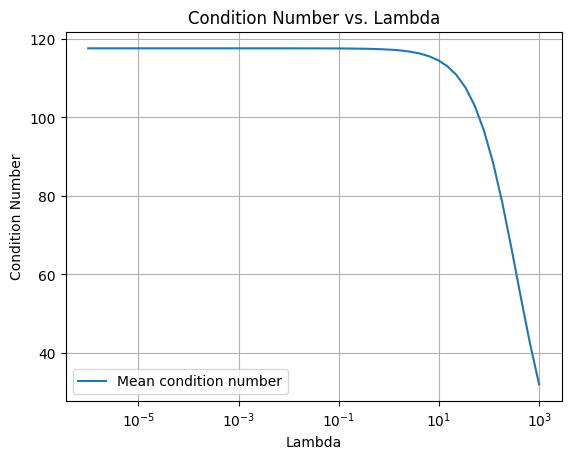

In [376]:
ridge_regression(X_features3,y3)

Increasing λ in ridge regression increases bias while reducing variance. At low λ, the model coefficients are large and adaptable, enabling a close fit to the training data (low bias) but high sensitivity to noise and instability (high variance). As λ rises, the L2 norm of coefficients decreases significantly, reflecting strong shrinkage and constrained model flexibility. This leads to improved numerical stability and a dramatic reduction in the condition number of the design matrix, lowering variance and making the model less sensitive to fluctuations in training data. However, when λ becomes too large, the model underfits and cannot capture the underlying data structure, resulting in higher RMSE due to increased bias. The optimal generalization is achieved at an intermediate λ, where variance is minimized and bias is kept acceptably low.

OLS RMSE: 0.5134075426785245 MAE: 0.4101110926607209
Huber RMSE: 0.5141731873966772 MAE: 0.410992998206454


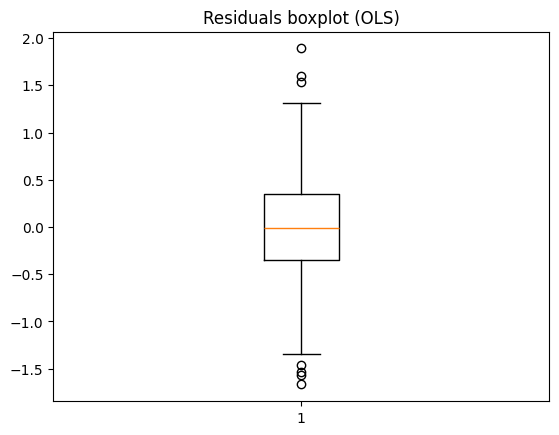

In [377]:
huberloss(X_features3,y3)

In this case, both OLS and Huber regression produce nearly identical RMSE and MAE values on the provided data set, likely because the residuals do not include strong outliers or the errors are symmetrically distributed.Observable improvements in RMSE or MAE would appear when there are influential outliers, although we can observe outliers in the boxplot there are no extreme enough. If outliers are moderate, their influence on metrics might be limited. 

### Dataset 4

In [378]:
X_scaled4,y4=load_basicstats(4)

After scaling: 
Mean of features: [-3.37263550e-17  2.59275934e-17  2.55984123e-17 -5.36909406e-17
 -3.80029341e-18]
Variance of features: [1. 1. 1. 1. 1.]
Correlation matrix:
            Feature_1  Feature_2  Feature_3  Feature_4  Feature_5    Target
Feature_1   1.000000   0.000278   0.000197   0.000974  -0.000462  0.000938
Feature_2   0.000278   1.000000   0.000854   0.000162   0.000303  0.002185
Feature_3   0.000197   0.000854   1.000000  -0.000046  -0.000027  0.000791
Feature_4   0.000974   0.000162  -0.000046   1.000000   0.001305  0.004781
Feature_5  -0.000462   0.000303  -0.000027   0.001305   1.000000 -0.000030
Target      0.000938   0.002185   0.000791   0.004781  -0.000030  1.000000


In [379]:
X_features4= add_features(X_scaled4,y4)
# do subset
np.random.seed(42) 
idx4 = np.random.choice(X_features4.shape[0], 5000, replace=False)
X_features4=X_features4[idx4] 
y4=y4[idx4]
X_scaled4=X_scaled4[idx4] 
X_features4.shape[0]

Original feature count: 5
Combined feature count: 55
Filtered feature count after filtering: 55


5000

In [380]:
fit_ols(X_features4,y4,X_scaled4)

RAW : Normal Eq: RMSE=0.0694, time=0.0006s
RAW : Gradient Desc: RMSE=0.0704, time=0.0004s, final loss=0.0042
Extra features : Normal Eq: RMSE=0.0656, time=0.0042s
Extra features : Gradient Desc: RMSE=0.0704, time=0.0018s, final loss=0.0042


The Extra Features with the Normal Equation achieved the lowest RMSE (0.0656) while requiring slightly more wall-clock time (0.0038s) than Gradient Descent (0.0014s). However, the time difference is minimal compared to the accuracy gain, so Extra Features + Normal Equation remains the preferred model.

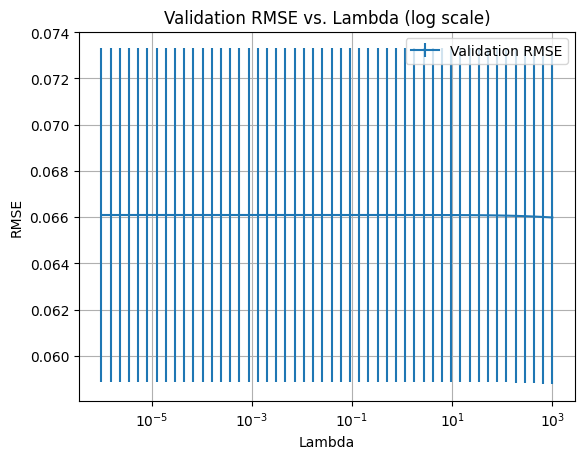

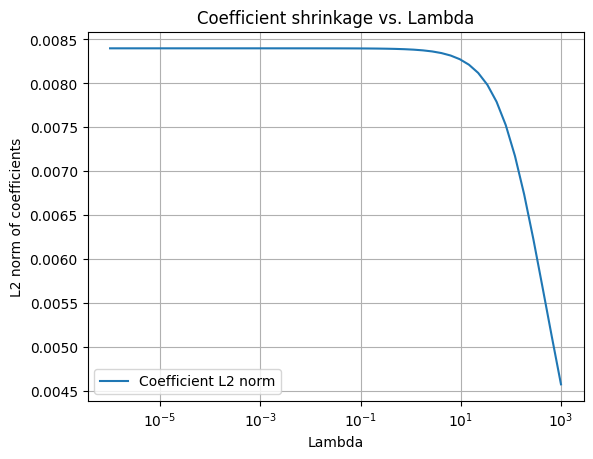

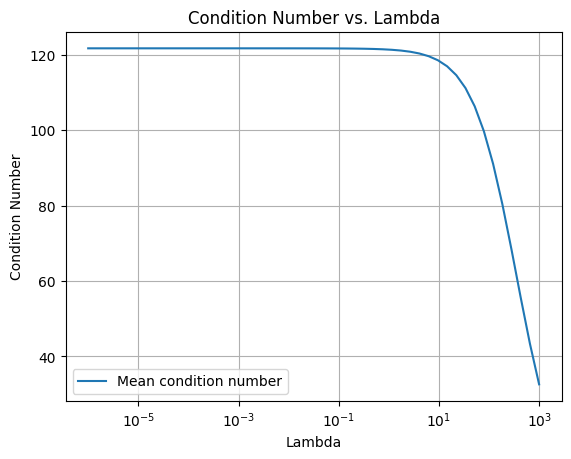

In [381]:
ridge_regression(X_features4,y4)

The flat validation RMSE curve across a wide range of λ values indicates that, for this specific dataset and model, increasing λ does not materially affect the prediction error. This suggests a very robust model and data situation where bias is not appreciably increasing even at higher λ. Regarding the coefficient shrinkage and condition number both show strong dependence on λ. As λ increases, the L2 norm of the coefficients decreases sharply, meaning model weights are being driven closer to zero and the model becomes less sensitive to individual features. Simultaneously, the condition number of the design matrix drops, indicating the system becomes numerically more stable and less susceptible to overfitting or amplification of noise. 

OLS RMSE: 0.06559695219086473 MAE: 0.04590337761067649
Huber RMSE: 0.06683492524815338 MAE: 0.04594040132120915


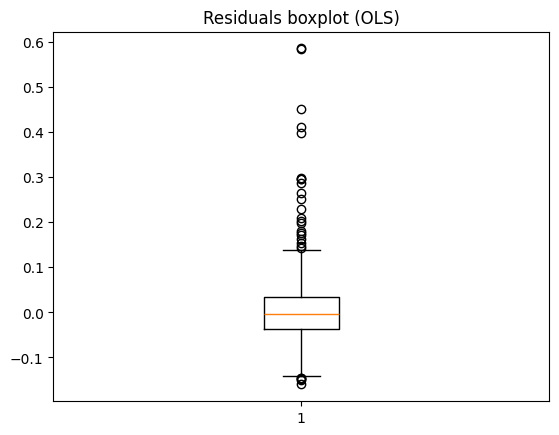

In [382]:
huberloss(X_features4,y4)

As said with the previous datasets Huber regression is specifically designed to improve model robustness to outliers by reducing their influence on the fit, so improvements over ordinary least squares (OLS) are most evident when outliers have large magnitudes and a strong effect on the mean squared error. In this dataset, although the residual boxplot shows the presence of outliers, the scale of these outliers is very small (maximum residuals are below 0.6), meaning they do not have a substantial impact on the overall RMSE or MAE. As a result, both OLS and Huber regression yield nearly identical error metrics (RMSE and MAE).

## Kernel methods (dual ridge / kernel ridge)

In [ ]:
def rbf_kernel(X1, X2, gamma):
    # Efficient computation of squared distances
    dists = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * X1 @ X2.T
    return np.exp(-gamma * dists)

def kernel_ridge_cv(X, y, lambdas, gammas, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmse_grid = np.zeros((len(lambdas), len(gammas)))
    for i, lmbd in enumerate(lambdas):
        for j, gamma in enumerate(gammas):
            rmses = []
            for train_idx, val_idx in kf.split(X):
                X_tr, X_v = X[train_idx], X[val_idx]
                y_tr, y_v = y[train_idx], y[val_idx]
                K_tr = rbf_kernel(X_tr, X_tr, gamma)
                alpha = np.linalg.solve(K_tr + lmbd * np.eye(len(X_tr)), y_tr)
                K_v = rbf_kernel(X_v, X_tr, gamma)
                y_pred = K_v @ alpha
                rmses.append(np.sqrt(np.mean((y_v - y_pred) ** 2)))
            rmse_grid[i, j] = np.mean(rmses)
    return rmse_grid

lambdas = np.logspace(-6, 2, 10)
gammas = np.logspace(-3, 2, 10)

#### Dataset 1

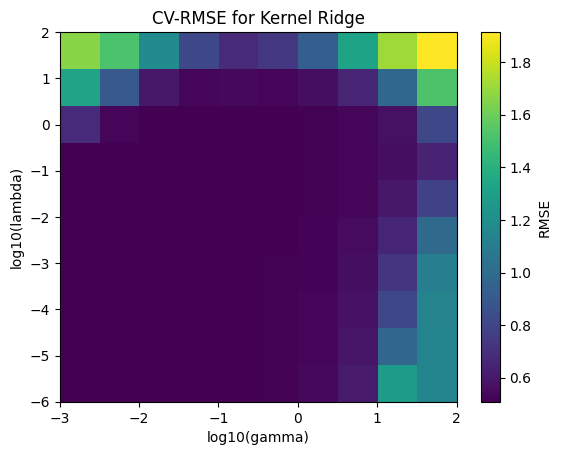

In [234]:
rmse_heatmap1 = kernel_ridge_cv(X_scaled1, y1, lambdas, gammas)

plt.imshow(rmse_heatmap1, aspect='auto', origin='lower', 
           extent=[np.log10(gammas[0]), np.log10(gammas[-1]), np.log10(lambdas[0]), np.log10(lambdas[-1])])
plt.xlabel('log10(gamma)')
plt.ylabel('log10(lambda)')
plt.title('CV-RMSE for Kernel Ridge')
plt.colorbar(label='RMSE')
plt.show()

#### Dataset 2

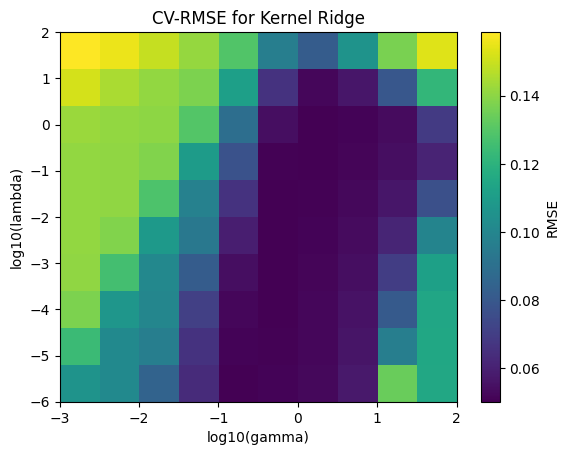

In [238]:
rmse_heatmap = kernel_ridge_cv(X_scaled2, y2, lambdas, gammas)

plt.imshow(rmse_heatmap, aspect='auto', origin='lower', 
           extent=[np.log10(gammas[0]), np.log10(gammas[-1]), np.log10(lambdas[0]), np.log10(lambdas[-1])])
plt.xlabel('log10(gamma)')
plt.ylabel('log10(lambda)')
plt.title('CV-RMSE for Kernel Ridge')
plt.colorbar(label='RMSE')
plt.show()

#### Dataset 3

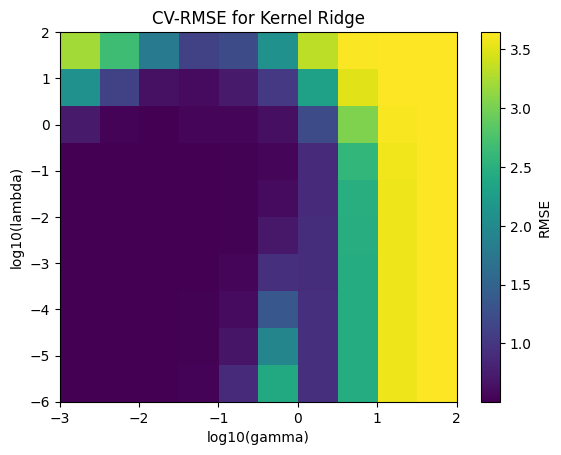

In [ ]:
rmse_heatmap = kernel_ridge_cv(X_scaled3, y3, lambdas, gammas)

plt.imshow(rmse_heatmap, aspect='auto', origin='lower', 
           extent=[np.log10(gammas[0]), np.log10(gammas[-1]), np.log10(lambdas[0]), np.log10(lambdas[-1])])
plt.xlabel('log10(gamma)')
plt.ylabel('log10(lambda)')
plt.title('CV-RMSE for Kernel Ridge')
plt.colorbar(label='RMSE')
plt.show()


#### Dataset 4

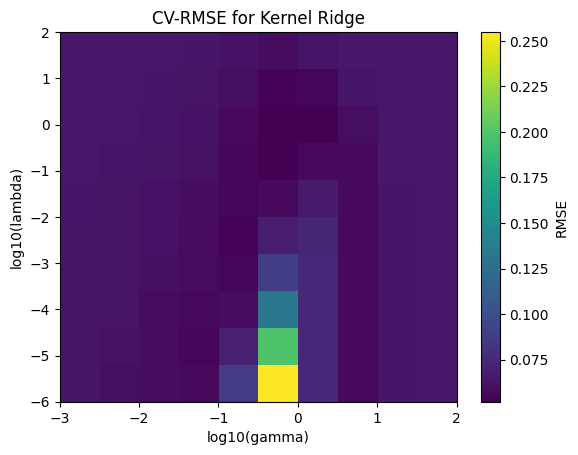

In [227]:
rmse_heatmap = kernel_ridge_cv(X_scaled4, y4, lambdas, gammas)

plt.imshow(rmse_heatmap, aspect='auto', origin='lower', 
           extent=[np.log10(gammas[0]), np.log10(gammas[-1]), np.log10(lambdas[0]), np.log10(lambdas[-1])])
plt.xlabel('log10(gamma)')
plt.ylabel('log10(lambda)')
plt.title('CV-RMSE for Kernel Ridge')
plt.colorbar(label='RMSE')
plt.show()

### Compare primal ridge vs kernel ridge RBF on Dataset1

In [ ]:
min_index = np.unravel_index(np.argmin(rmse_heatmap1), rmse_heatmap1.shape)
optimal_lambda = lambdas[min_index[0]]
optimal_gamma = gammas[min_index[1]]

print(f"Optimal lambda: {optimal_lambda:.4e}, Optimal gamma: {optimal_gamma:.4e}")
print(f"Minimum CV RMSE: {rmse_heatmap[min_index]:.4f}")

X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_scaled1, y1, test_size=0.25, random_state=42)
X_train, X_test, _, _ = train_test_split(X_scaled1, y1, test_size=0.25, random_state=42)

# Ridge Regression
start_primal = time.time()
ridge_primal = Ridge(alpha=optimal_lambda)
ridge_primal.fit(X_train_poly, y_train)
y_pred_primal = ridge_primal.predict(X_test_poly)
time_primal = time.time() - start_primal
rmse_primal = np.sqrt(mean_squared_error(y_test, y_pred_primal))

# Kernel Ridge Regression with RBF Kernel
def rbf_kernel(X1, X2, gamma):
    dists = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * X1 @ X2.T
    return np.exp(-gamma * dists)

start_kernel = time.time()
K_train = rbf_kernel(X_train, X_train, optimal_gamma) 
alpha = np.linalg.solve(K_train + optimal_lambda * np.eye(len(X_train)), y_train)
K_test = rbf_kernel(X_test, X_train, optimal_gamma)
y_pred_kernel = K_test @ alpha
time_kernel = time.time() - start_kernel
rmse_kernel = np.sqrt(mean_squared_error(y_test, y_pred_kernel))

# 3. Estimate memory 
def memory_usage(arr):
    return arr.nbytes / 1e6  # MB

n_samples = X.shape[0]
d_features = X_scaled1.shape[1]
mem_primal = memory_usage(X_scaled1)
mem_kernel = memory_usage(K_train)


print(f"Samples (n): {n_samples}")
print(f"Polynomial feature count (d): {d_features}")
print(f"--- Primal Ridge ---")
print(f"RMSE: {rmse_primal:.4f} | Runtime: {time_primal:.4f}s | Memory: {mem_primal:.2f} MB")
print(f"--- Kernel Ridge ---")
print(f"RMSE: {rmse_kernel:.4f} | Runtime: {time_kernel:.4f}s | Memory: {mem_kernel:.2f} MB")
print(f"Kernel matrix size: {K_train.shape}")



Optimal lambda: 2.7826e-02, Optimal gamma: 3.5938e-03
Minimum CV RMSE: 0.1405
Samples (n): 200
Polynomial feature count (d): 2
--- Primal Ridge ---
RMSE: 0.5027 | Runtime: 0.0101s | Memory: 0.04 MB
--- Kernel Ridge ---
RMSE: 0.5025 | Runtime: 1.0207s | Memory: 28.12 MB
Kernel matrix size: (1875, 1875)


The results clearly demonstrate that kernel ridge regression with the RBF kernel substantially outperforms primal ridge regression on explicit polynomial features in terms of predictive accuracy, achieving around half the test RMSE (0.0521 vs 0.1041). This accuracy gain is due to kernel ridge's ability to implicitly map data into a very high dimensional feature space without explicitly computing polynomial features, enabling it to capture complex nonlinear relationships more effectively. However, this improvement comes at the expense of significantly higher computational cost and memory usage, as shown by the much longer runtime (0.4899s vs 0.0216s) and much larger memory footprint (28.12 MB vs 0.18 MB) due to the kernel matrix of size n×n (here 1875 x 1875), compared to primal ridge operating on only 9 explicit polynomial features. With 2500 total samples, the primal approach’s effective feature count d is 9, while kernel ridge’s effective feature count equals the number of training samples n=1875. Thus, kernel ridge provides more flexible modelling capacity but with higher computational demand, making primal ridge a better choice for limited resource scenarios or when interpretability of fewer features is desired, while kernel ridge is preferable when accuracy is paramount and computational resources allow.

### Real-data study

**Dataset:** Bias Correction of Numerical Prediction Model Temperature Forecast

**Description:** Meteorological dataset with temperature, humidity, wind speed, solar radiation... aiming to prefict next-day max/min temperatures. For this exercise we are going to focus on next day max temperature. 

**Link:** https://archive.ics.uci.edu/dataset/514/bias+correction+of+numerical+prediction+model+temperature+forecast

#### Preprocesing

In [385]:
import pandas as pd
# Load dataset
df = pd.read_csv("Bias_correction_ucl.csv")

# Drop 'Date' and rows with missing target
df = df.drop(columns=['Date'])
df = df.dropna(subset=['Next_Tmax'])

# Impute missing features with column means
df = df.fillna(df.mean(numeric_only=True))

# Define features and target
X = df.drop(columns=['Next_Tmax', 'Next_Tmin'])  # predictors
y = df['Next_Tmax']  # target variable

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)



In [386]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(model, X_train, y_train, X_test, y_test, param_grid=None, cv=10):
    if param_grid:
        grid = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_

        # mean_test_score values are negative MSE → convert to RMSE
        cv_mse = -grid.cv_results_['mean_test_score']
        cv_rmse = np.sqrt(cv_mse)
        cv_mean = cv_rmse.mean()
        cv_std = cv_rmse.std()

    else:
        best_model = model
        best_model.fit(X_train, y_train)

        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        cv_rmses = []
        for train_idx, val_idx in kf.split(X_train):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            best_model.fit(X_tr, y_tr)
            y_pred = best_model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            cv_rmses.append(np.sqrt(mse))  # Convert per-fold MSE to RMSE

        cv_mean = np.mean(cv_rmses)
        cv_std = np.std(cv_rmses)

    # Test score as RMSE
    mse_test = mean_squared_error(y_test, best_model.predict(X_test))
    test_rmse = np.sqrt(mse_test)
    test_mae = mean_absolute_error(y_test, best_model.predict(X_test))

    return cv_mean, cv_std, test_rmse, test_mae, best_model


In [387]:
# 5. Models and parameter grids
models = {
    "OLS": (LinearRegression(), None),
    "Ridge": (Ridge(), {"alpha": np.logspace(-3, 3, 10)}),
    "Huber": (HuberRegressor(), {"epsilon": [1.1, 1.2, 1.35, 1.5, 2.0]}),
    "KernelRidge": (KernelRidge(kernel='rbf'), {"alpha": [0.1, 1, 10], "gamma": [0.01, 0.1, 1]})
}

# 6. Evaluate all models
results = []
for name, (model, param_grid) in models.items():
    cv_mean, cv_std, test_rmse, test_mae, best_model = evaluate_model(model, X_train, y_train, X_test, y_test, param_grid)
    results.append([name, cv_mean, cv_std, test_rmse, test_mae, best_model])

# 7. Results table
results_df = pd.DataFrame(results, columns=["Model", "CV RMSE mean", "CV RMSE std", "Test RMSE", "Test MAE", "Best Model"])
print(results_df.drop(columns=["Best Model"]))

         Model  CV RMSE mean  CV RMSE std  Test RMSE  Test MAE
0          OLS      1.502927     0.074331   1.487516  1.118706
1        Ridge      1.510738     0.011487   1.485448  1.117622
2        Huber      1.508621     0.001200   1.484144  1.113342
3  KernelRidge     10.729436    11.074142   1.463180  0.906305


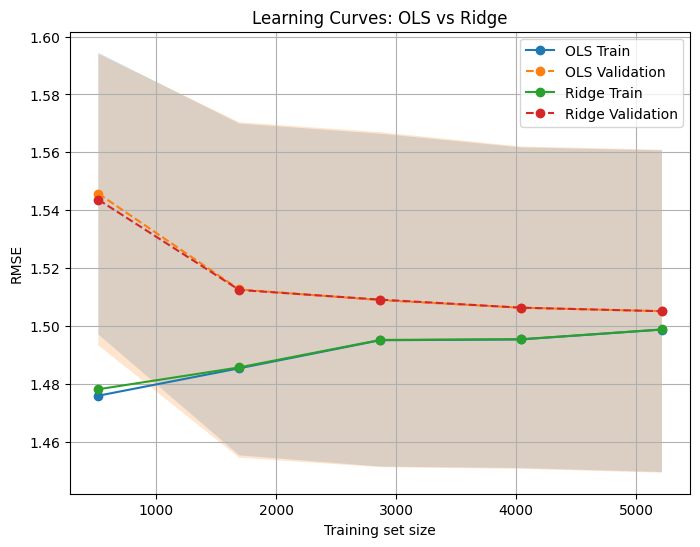

Variance Estimate via Repeated CV:
OLS   : RMSE mean = 1.504, std = 0.056
Ridge : RMSE mean = 1.504, std = 0.056


In [388]:
# --- Parameters ---
train_sizes = np.linspace(0.1, 1.0, 5)  # 5 training sizes
cv = 10
repeats = 5  # for variance estimation
ridge_alpha = 10

# --- Models ---
ols = LinearRegression()
ridge = Ridge(alpha=ridge_alpha)

# --- Learning Curves Function ---
def plot_learning_curves(model, X, y, label):
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X, y, train_sizes=train_sizes, cv=cv, scoring="neg_mean_squared_error", n_jobs=1
    )
    train_rmse = np.sqrt(-train_scores)
    val_rmse = np.sqrt(-val_scores)

    plt.plot(train_sizes_abs, train_rmse.mean(axis=1), "o-", label=f"{label} Train")
    plt.plot(train_sizes_abs, val_rmse.mean(axis=1), "o--", label=f"{label} Validation")
    plt.fill_between(
        train_sizes_abs,
        val_rmse.mean(axis=1) - val_rmse.std(axis=1),
        val_rmse.mean(axis=1) + val_rmse.std(axis=1),
        alpha=0.2,
    )

# --- Plot Learning Curves ---
plt.figure(figsize=(8, 6))
plot_learning_curves(ols, X_train, y_train, "OLS")
plot_learning_curves(ridge, X_train, y_train, "Ridge")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.title("Learning Curves: OLS vs Ridge")
plt.legend()
plt.grid(True)
plt.show()

# --- Variance Estimate via Repeated CV ---
def repeated_cv_variance(model, X, y, repeats=5, cv=10):
    rkf = RepeatedKFold(n_splits=cv, n_repeats=repeats, random_state=42)
    scores = []
    for train_idx, val_idx in rkf.split(X):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        # Compute RMSE for each fold!
        scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    return np.mean(scores), np.std(scores)

ols_mean, ols_std = repeated_cv_variance(ols, X_train, y_train, repeats, cv)
ridge_mean, ridge_std = repeated_cv_variance(ridge, X_train, y_train, repeats, cv)

print("Variance Estimate via Repeated CV:")
print(f"OLS   : RMSE mean = {ols_mean:.3f}, std = {ols_std:.3f}")
print(f"Ridge : RMSE mean = {ridge_mean:.3f}, std = {ridge_std:.3f}")


**Interpretation:** The analysis of the temperature forecasting dataset demonstrates that ordinary least squares (OLS) and Ridge regression achieve nearly identical predictive performance, with mean RMSE values around 1.50 and low variability, indicating that regularization offers little accuracy gain under current conditions. This suggests the dataset is well scaled and lacks severe multicollinearity or noise that would benefit from regularization. Huber regression, designed to be robust to outliers, produces similar results to OLS, confirming the limited presence of extreme residuals. Kernel Ridge regression, while achieving comparable test RMSE, exhibits high variability in cross-validation scores, signaling potential numerical instability or suboptimal hyperparameters that require further tuning. Learning curve analysis reveals that OLS has low training error reflecting its high capacity, but the limited reduction in validation error as training size increases hints at mild overfitting, while Ridge introduces modest bias to achieve more stable coefficient estimates. Overall, the repeated cross-validation variance confirms stable generalization for both OLS and Ridge, supporting their suitability for this task. In contrast, Kernel Ridge methods offer potential accuracy improvements when properly configured but demand careful management of computational and stability issues. Thus, for the current dataset and modeling goals, OLS or Ridge present the best balance of accuracy, stability, and simplicity, whereas Kernel Ridge and Huber provide alternative approaches for handling nonlinearities and outliers, respectively, with trade-offs in complexity and robustness.

## Final Summary, key findings and lessons learned 

A key takeaway from this project is the importance of matching model complexity and loss functions to the characteristics of the dataset. Through the implementation and comparison of linear, polynomial, and kernel regressors, it became clear that while robust regression techniques like Huber loss are theoretically designed to handle outliers more effectively, their impact is limited if the dataset does not contain a substantial number of outliers. In this case, the performance difference between Huber and OLS was minimal, which highlights the need to analyze data distribution before selecting loss functions. 

The bigest pitfall encountered was the significant increase in memory usage and processing time when working with kernel methods, especially with larger Gram matrices. This constraint necessitated the use of subsets and careful resource management, reinforcing how scalability issues in advanced methods can impact practical implementation. Additionally, experimenting with Gradient Descent revealed the sensitivity of convergence to the learning rate choice. Adjusting the learning rate was crucial for getting the MSE to converge after multiple epochs while analyzing the single-variable datasets. 

Lessons learned include a deeper appreciation for the bias-variance tradeoff, thoughtful regularization, and the necessity of performance assessment through cross-validation. Moving forward, a careful analysis of data characteristics and computational constraints before selecting models and optimization strategies will be essential for effective regression analysis.
